In [28]:
# Jupyter notebook in Jupytext format

## Initialisation

In [29]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\ode-biomarker-project


In [30]:
from PathLoader import PathLoader #noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [31]:
from DataLink import DataLink #noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [32]:
folder_name = "ThesisResult4-FeatureSelectionBenchmark"
exp_id = "v5_mrmr_vs_gffs_anova_prefilter"

if not os.path.exists(f"{path_loader.get_data_path()}data/results/{folder_name}/{exp_id}"):
    os.makedirs(f"{path_loader.get_data_path()}data/results/{folder_name}/{exp_id}")

file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/{exp_id}/"

In [33]:
# Load Proteomics Palbociclib dataset
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(
    loading_code
)

print(f"Proteomic feature data shape: {proteomic_feature_data.shape}")
print(f"Proteomic label data shape: {proteomic_label_data.shape}")

Proteomic feature data shape: (737, 6692)
Proteomic label data shape: (737,)


In [34]:
# Data preparation and alignment
import numpy as np #noqa: E402

# Ensure numeric only
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Align indices
common_indices = sorted(
    set(proteomic_feature_data.index) & set(proteomic_label_data.index)
)
feature_data = proteomic_feature_data.loc[common_indices]
label_data = proteomic_label_data.loc[common_indices]

print(f"Final aligned dataset shape: {feature_data.shape}")
print(f"Final aligned label shape: {label_data.shape}")

Final aligned dataset shape: (737, 6692)
Final aligned label shape: (737,)


## Functions

In [35]:
from typing import Dict, List, Literal #noqa: E402
import numpy as np #noqa: E402
import pandas as pd #noqa: E402
from scipy.stats import pearsonr, spearmanr #noqa: E402
from sklearn.metrics import r2_score #noqa: E402
from sklearn.dummy import DummyRegressor #noqa: E402
from sklearn.preprocessing import StandardScaler #noqa: E402
from toolkit import FirstQuantileImputer, f_regression_select, get_model_from_string #noqa: E402
from toolkit import (
    mrmr_select_fcq, 
    mrmr_select_fcq_fast,
    mutual_information_select,
    select_random_features,
) #noqa: E402
import time #noqa: E402

In [36]:
def random_select_wrapper(X: pd.DataFrame, y: pd.Series, k: int) -> tuple:
    """Wrapper function for random feature selection that returns dummy scores"""
    selected_features, _ = select_random_features(X, y, k)
    # Return dummy scores (all zeros) since random selection has no meaningful scores
    dummy_scores = np.zeros(len(selected_features))
    return selected_features, dummy_scores

In [37]:
def _drop_correlated_columns(X: pd.DataFrame, threshold: float = 0.95) -> List[str]:
    """Drop highly correlated columns to reduce redundancy"""
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    for col in sorted(upper.columns):
        if col in to_drop:
            continue
        high_corr = upper.index[upper[col] > threshold].tolist()
        to_drop.update(high_corr)
    return [c for c in X.columns if c not in to_drop]

In [38]:
def create_feature_selection_pipeline(
    selection_method: callable, k: int, method_name: str, model_name: str
):
    """Create pipeline for feature selection methods"""

    def pipeline_function(X_train: pd.DataFrame, y_train: pd.Series, rng: int):
        # 1) Sanitize inputs and imputation
        X_train = X_train.replace([np.inf, -np.inf], np.nan)
        y_train = pd.Series(y_train).replace([np.inf, -np.inf], np.nan)
        mask = ~y_train.isna()
        X_train, y_train = X_train.loc[mask], y_train.loc[mask]

        # 2) Imputation
        imputer = FirstQuantileImputer().fit(X_train)
        Xtr = imputer.transform(X_train, return_df=True).astype(float)
        Xtr = Xtr.fillna(0.0)

        # 3) Correlation filtering (applied to both train and test)
        # Use the working function from your baseline code [1]
        corr_keep_cols = _drop_correlated_columns(Xtr, threshold=0.95)
        Xtr_filtered = Xtr[corr_keep_cols]

        # 4) Feature selection
        k_sel = min(k, Xtr_filtered.shape[1]) if Xtr_filtered.shape[1] > 0 else 0
        if k_sel == 0:
            selected_features, selector_scores = [], np.array([])
            no_features = True
        else:
            selected_features, selector_scores = selection_method(
                Xtr_filtered, y_train, k_sel
            )
            no_features = False

        # 5) Standardization and model training
        if no_features or len(selected_features) == 0:
            model = DummyRegressor(strategy="mean")
            model_type = "DummyRegressor(mean)"
            model_params = {"strategy": "mean"}
            sel_train = Xtr_filtered.iloc[:, :0]
        else:
            sel_train = Xtr_filtered[selected_features]
            scaler = StandardScaler()
            sel_train_scaled = scaler.fit_transform(sel_train)
            sel_train_scaled = pd.DataFrame(
                sel_train_scaled, index=sel_train.index, columns=selected_features
            )

            # Train model
            if model_name == "LinearRegression":
                model = get_model_from_string("LinearRegression")
            elif model_name == "KNeighborsRegressor":
                model = get_model_from_string(
                    "KNeighborsRegressor", n_neighbors=5, weights="distance", p=2
                )
            elif model_name == "SVR":
                model = get_model_from_string("SVR", kernel="linear", C=1.0)
            else:
                raise ValueError(f"Unsupported model: {model_name}")

            model.fit(sel_train_scaled, y_train)
            model_type = model_name
            model_params = (
                model.get_params(deep=False) if hasattr(model, "get_params") else {}
            )

        return {
            "imputer": imputer,
            "corr_keep_cols": corr_keep_cols,
            "selected_features": list(selected_features),
            "selector_scores": np.array(selector_scores),
            "model": model,
            "model_type": model_type,
            "model_params": model_params,
            "scaler": scaler if not no_features else None,
            "no_features": no_features,
            "rng": rng,
        }

    return pipeline_function

In [39]:
def feature_selection_eval(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    pipeline_components: Dict,
    metric_primary: Literal["r2", "pearson_r", "spearman_r"] = "r2",
) -> Dict:
    """Evaluation function for feature selection benchmarking"""

    # Unpack components following the structure from working baseline code [1]
    imputer = pipeline_components["imputer"]
    corr_keep = set(pipeline_components["corr_keep_cols"])
    selected = list(pipeline_components["selected_features"])
    selector_scores = pipeline_components["selector_scores"]
    model = pipeline_components["model"]
    model_name = pipeline_components["model_type"]
    scaler = pipeline_components.get("scaler", None)
    no_features = pipeline_components.get("no_features", False)

    # Apply identical transforms as training
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    y_test = pd.Series(y_test).replace([np.inf, -np.inf], np.nan)
    mask_y = ~y_test.isna()
    X_test, y_test = X_test.loc[mask_y], y_test.loc[mask_y]

    Xti = imputer.transform(X_test, return_df=True).astype(float).fillna(0.0)

    # Apply same correlation filtering as training [1]
    cols_after_corr = [c for c in Xti.columns if c in corr_keep]
    Xti = Xti[cols_after_corr]

    # Select features
    Xsel = Xti[selected] if len(selected) > 0 else Xti.iloc[:, :0]

    # Standardize if scaler exists (i.e., features were selected)
    if scaler is not None and len(selected) > 0:
        Xsel_scaled = scaler.transform(Xsel)
        Xsel_scaled = pd.DataFrame(Xsel_scaled, index=Xsel.index, columns=selected)
    else:
        Xsel_scaled = Xsel

    # Predict
    if no_features or Xsel.shape[1] == 0:
        y_pred = np.full_like(
            y_test.values, fill_value=float(y_test.mean()), dtype=float
        )
    else:
        y_pred = np.asarray(model.predict(Xsel_scaled), dtype=float)

    # Calculate metrics (following the exact structure from baseline_eval [1])
    mask_fin = np.isfinite(y_test.values) & np.isfinite(y_pred)
    y_t = y_test.values[mask_fin]
    y_p = y_pred[mask_fin]

    if len(y_t) < 2:
        r2 = np.nan
        pearson_r = pearson_p = np.nan
        spearman_rho = spearman_p = np.nan
    else:
        r2 = r2_score(y_t, y_p)
        pearson_r, pearson_p = pearsonr(y_t, y_p)
        spearman_rho, spearman_p = spearmanr(y_t, y_p)

    metrics = {
        "r2": float(r2) if np.isfinite(r2) else np.nan,
        "pearson_r": float(pearson_r) if np.isfinite(pearson_r) else np.nan,
        "pearson_p": float(pearson_p) if np.isfinite(pearson_p) else np.nan,
        "spearman_rho": float(spearman_rho) if np.isfinite(spearman_rho) else np.nan,
        "spearman_p": float(spearman_p) if np.isfinite(spearman_p) else np.nan,
        "n_test_samples_used": len(y_t),
    }

    # Feature importance
    if not no_features and hasattr(model, "feature_importances_") and len(selected) > 0:
        fi = (np.array(selected), model.feature_importances_)
    elif not no_features and model_name in ("LinearRegression",) and len(selected) > 0:
        coef = getattr(model, "coef_", np.zeros(len(selected)))
        fi = (np.array(selected), np.abs(coef))
    else:
        fi = (np.array(selected), np.zeros(len(selected)))

    primary = metrics.get(metric_primary, metrics["r2"])

    return {
        "feature_importance": fi,
        "feature_importance_from": "model",
        "model_performance": float(primary) if primary is not None else np.nan,
        "metrics": metrics,
        "selected_features": selected,
        "model_name": model_name,
        "selected_scores": selector_scores,
        "k": len(selected),
        "rng": pipeline_components.get("rng", None),
        "y_pred": y_p,
        "y_true_index": y_test.index[mask_fin],
    }

## Results and Visualisation

### Load data

In [40]:
def save_and_print(message, report_file=None, level="info"):
    """
    Print message to console and save to report file with proper formatting.
    
    Args:
        message: The message to print and save
        report_file: File object to save to (optional)
        level: Formatting level - "header", "section", "subsection", or "info"
    """
    # Print to console
    print(message)
    
    # Save to report with proper formatting
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:  # info level
            report_file.write(f"{message}\n\n")
    
    return message

In [41]:
# Load saved feature selection benchmark (feature_selection_benchmark_v1.pkl)
import os
import pandas as pd
import time #noqa: E402

# Create a new report file for capturing print statements
print_report_path = f"{file_save_path}feature_selection_print_report_{exp_id}.md"
print_report_file = open(print_report_path, 'w', encoding='utf-8')

# Write header to the print report
print_report_file.write(f"# Feature Selection Print Report - {exp_id}\n\n")
print_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
print_report_file.write("This report captures all print statements from the Results section with proper formatting.\n\n")

pkl_path = f"{path_loader.get_data_path()}data/results/{folder_name}/feature_selection_benchmark_{exp_id}.pkl"
if not os.path.exists(pkl_path):
    raise FileNotFoundError(f"Pickle not found: {pkl_path}")

df_benchmark = pd.read_pickle(pkl_path)
save_and_print(f"Loaded df_benchmark with shape: {df_benchmark.shape}", print_report_file, level="section")
# Display first rows (works in notebook)
try:
    from IPython.display import display

    display(df_benchmark.head())
except Exception:
    save_and_print(df_benchmark.head().to_string(), print_report_file, level="info")

# Re-define variables that might be needed in the loaded section
# Dynamically detect available methods, models, and k-values from the data
feature_set_sizes = sorted(df_benchmark['k_value'].unique())
models = df_benchmark['model_name'].unique().tolist()

# Dynamically create method labels based on available methods
available_methods = df_benchmark['method'].unique().tolist()
method_labels = {}
for method in available_methods:
    if method == 'anova':
        method_labels[method] = 'ANOVA-Filter'
    elif method == 'mrmr':
        method_labels[method] = 'MRMR'
    elif method == 'mutual':
        method_labels[method] = 'Mutual Information'
    elif method == 'random':
        method_labels[method] = 'Random Selection'
    else:
        # For any new methods not predefined, use the method name as label
        method_labels[method] = method.title()

print(f"Actual k-values present in data: {feature_set_sizes}")
print(f"Available methods: {available_methods}")
print(f"Available models: {models}")

Loaded df_benchmark with shape: (240, 15)


,rng,condition,feature_importance,feature_importance_from,model_performance,metrics,selected_features,model_name,selected_scores,k,y_pred,y_true_index,feature_selection_time,k_value,method
0,15795,mrmr_anova_prefilter_k5_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.279471,"{'r2': 0.2794712375708762, 'pearson_r': 0.5522...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",prefilter,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.14789927045426, 4.688879413889946, 4.656151...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.101920,5,mrmr
1,15795,mrmr_anova_prefilter_k5_LinearRegression,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.336319,"{'r2': 0.33631912107220674, 'pearson_r': 0.589...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",prefilter,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.428014441241061, 4.1337004127084125, 4.3270...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.092763,5,mrmr
2,15795,mrmr_anova_prefilter_k5_SVR,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.305427,"{'r2': 0.3054269285272425, 'pearson_r': 0.5630...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",prefilter,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.423449424539447, 4.117507989298452, 4.34772...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.095507,5,mrmr
3,15795,mrmr_anova_prefilter_k10_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.334586,"{'r2': 0.33458645217475047, 'pearson_r': 0.600...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",prefilter,"[223.43343259944592, 345.85840610155753, 396.8...",10,"[4.60774204069447, 3.69462151081767, 5.3141995...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.098269,10,mrmr
4,15795,mrmr_anova_prefilter_k10_LinearRegression,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.345401,"{'r2': 0.34540087934582, 'pearson_r': 0.596166...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",prefilter,"[223.43343259944592, 345.85840610155753, 396.8...",10,"[4.4835527131671356, 4.1612553470953095, 4.422...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.103936,10,mrmr


Actual k-values present in data: [np.int64(5), np.int64(10), np.int64(20), np.int64(40)]
Available methods: ['mrmr', 'gffs']
Available models: ['prefilter']


### Fix Data Structure Issues

In [42]:
def parse_condition_column(df_benchmark):
    """Parse the condition column to extract method, k_value, and model_name correctly"""
    
    save_and_print("## Fixing Data Structure Issues", print_report_file, level="section")
    save_and_print("Parsing condition column to extract correct method, k_value, and model_name", print_report_file, level="info")
    
    # Create new columns based on condition parsing
    parsed_data = []
    
    for idx, row in df_benchmark.iterrows():
        condition = row['condition']
        
        # Parse the condition format: {method}_k{value}_{model}
        # Example: "mrmr_anova_prefilter_k5_KNeighborsRegressor"
        parts = condition.split('_')
        
        # Extract method (everything before the k-value part)
        method_parts = []
        k_value = None
        model_name = None
        
        for part in parts:
            if part.startswith('k'):
                # Found k-value part, extract numeric value
                k_value = int(part[1:])  # Remove 'k' prefix and convert to int
                # Everything before this is the method
                method = '_'.join(method_parts)
                # Everything after this is the model
                model_parts = parts[parts.index(part) + 1:]
                model_name = '_'.join(model_parts)
                break
            else:
                method_parts.append(part)
        
        # If we didn't find a k-value (shouldn't happen with valid data)
        if k_value is None:
            save_and_print(f"Warning: Could not parse k-value from condition: {condition}", print_report_file, level="info")
            method = '_'.join(method_parts[:-1]) if len(method_parts) > 1 else method_parts[0]
            model_name = parts[-1] if parts else 'unknown'
            k_value = 0
        
        parsed_data.append({
            'condition': condition,
            'parsed_method': method,
            'parsed_k_value': k_value,
            'parsed_model_name': model_name
        })
    
    # Create a DataFrame with parsed values
    parsed_df = pd.DataFrame(parsed_data)
    
    # Compare with existing columns
    save_and_print("### Comparison of Original vs Parsed Values", print_report_file, level="subsection")
    
    # Check method consistency
    method_mismatch = df_benchmark['method'] != parsed_df['parsed_method']
    if method_mismatch.any():
        save_and_print(f"Method mismatches found: {method_mismatch.sum()}/{len(df_benchmark)}", print_report_file, level="info")
        for idx in df_benchmark[method_mismatch].index[:5]:  # Show first 5 mismatches
            save_and_print(f"  Row {idx}: Original='{df_benchmark.loc[idx, 'method']}', Parsed='{parsed_df.loc[idx, 'parsed_method']}'", 
                          print_report_file, level="info")
    
    # Check k_value consistency
    k_mismatch = df_benchmark['k_value'] != parsed_df['parsed_k_value']
    if k_mismatch.any():
        save_and_print(f"K-value mismatches found: {k_mismatch.sum()}/{len(df_benchmark)}", print_report_file, level="info")
        for idx in df_benchmark[k_mismatch].index[:5]:
            save_and_print(f"  Row {idx}: Original={df_benchmark.loc[idx, 'k_value']}, Parsed={parsed_df.loc[idx, 'parsed_k_value']}", 
                          print_report_file, level="info")
    
    # Check model_name consistency
    model_mismatch = df_benchmark['model_name'] != parsed_df['parsed_model_name']
    if model_mismatch.any():
        save_and_print(f"Model name mismatches found: {model_mismatch.sum()}/{len(df_benchmark)}", print_report_file, level="info")
        for idx in df_benchmark[model_mismatch].index[:5]:
            save_and_print(f"  Row {idx}: Original='{df_benchmark.loc[idx, 'model_name']}', Parsed='{parsed_df.loc[idx, 'parsed_model_name']}'", 
                          print_report_file, level="info")
    
    # Update the dataframe with parsed values
    df_benchmark['method'] = parsed_df['parsed_method']
    df_benchmark['k_value'] = parsed_df['parsed_k_value']
    df_benchmark['model_name'] = parsed_df['parsed_model_name']
    
    save_and_print("Dataframe columns updated with correctly parsed values", print_report_file, level="info")
    
    # Show unique values after parsing
    save_and_print("### Unique Values After Parsing", print_report_file, level="subsection")
    save_and_print(f"Methods: {df_benchmark['method'].unique()}", print_report_file, level="info")
    save_and_print(f"K-values: {sorted(df_benchmark['k_value'].unique())}", print_report_file, level="info")
    save_and_print(f"Models: {df_benchmark['model_name'].unique()}", print_report_file, level="info")
    
    return df_benchmark

# Apply the parsing fix
df_benchmark = parse_condition_column(df_benchmark)

# Display first rows (works in notebook)
try:
    from IPython.display import display

    display(df_benchmark.head())
except Exception:
    save_and_print(df_benchmark.head().to_string(), print_report_file, level="info")
    
# Re-define variables that might be needed in the loaded section
# Dynamically detect available methods, models, and k-values from the data
feature_set_sizes = sorted(df_benchmark["k_value"].unique())
models = df_benchmark["model_name"].unique().tolist()

# Dynamically create method labels based on available methods
available_methods = df_benchmark["method"].unique().tolist()
method_labels = {}
for method in available_methods:
    if method == "anova":
        method_labels[method] = "ANOVA-Filter"
    elif method == "mrmr":
        method_labels[method] = "MRMR"
    elif method == "mutual":
        method_labels[method] = "Mutual Information"
    elif method == "random":
        method_labels[method] = "Random Selection"
    else:
        # For any new methods not predefined, use the method name as label
        method_labels[method] = method.title()

print(f"Actual k-values present in data: {feature_set_sizes}")
print(f"Available methods: {available_methods}")
print(f"Available models: {models}")

## Fixing Data Structure Issues
Parsing condition column to extract correct method, k_value, and model_name
### Comparison of Original vs Parsed Values
Method mismatches found: 240/240
  Row 0: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 1: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 2: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 3: Original='mrmr', Parsed='mrmr_anova_prefilter'
  Row 4: Original='mrmr', Parsed='mrmr_anova_prefilter'
Model name mismatches found: 240/240
  Row 0: Original='prefilter', Parsed='KNeighborsRegressor'
  Row 1: Original='prefilter', Parsed='LinearRegression'
  Row 2: Original='prefilter', Parsed='SVR'
  Row 3: Original='prefilter', Parsed='KNeighborsRegressor'
  Row 4: Original='prefilter', Parsed='LinearRegression'
Dataframe columns updated with correctly parsed values
### Unique Values After Parsing
Methods: ['mrmr_anova_prefilter' 'gffs_anova_prefilter']
K-values: [np.int64(5), np.int64(10), np.int64(20), np.int64(40)]
Models: ['

,rng,condition,feature_importance,feature_importance_from,model_performance,metrics,selected_features,model_name,selected_scores,k,y_pred,y_true_index,feature_selection_time,k_value,method
0,15795,mrmr_anova_prefilter_k5_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.279471,"{'r2': 0.2794712375708762, 'pearson_r': 0.5522...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",KNeighborsRegressor,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.14789927045426, 4.688879413889946, 4.656151...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.101920,5,mrmr_anova_prefilter
1,15795,mrmr_anova_prefilter_k5_LinearRegression,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.336319,"{'r2': 0.33631912107220674, 'pearson_r': 0.589...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",LinearRegression,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.428014441241061, 4.1337004127084125, 4.3270...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.092763,5,mrmr_anova_prefilter
2,15795,mrmr_anova_prefilter_k5_SVR,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.305427,"{'r2': 0.3054269285272425, 'pearson_r': 0.5630...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",SVR,"[223.43343259944592, 345.85840610155753, 396.8...",5,"[4.423449424539447, 4.117507989298452, 4.34772...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.095507,5,mrmr_anova_prefilter
3,15795,mrmr_anova_prefilter_k10_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.334586,"{'r2': 0.33458645217475047, 'pearson_r': 0.600...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",KNeighborsRegressor,"[223.43343259944592, 345.85840610155753, 396.8...",10,"[4.60774204069447, 3.69462151081767, 5.3141995...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.098269,10,mrmr_anova_prefilter
4,15795,mrmr_anova_prefilter_k10_LinearRegression,"([O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O9529...",model,0.345401,"{'r2': 0.34540087934582, 'pearson_r': 0.596166...","[O60716;CTND1_HUMAN, P32519;ELF1_HUMAN, O95292...",LinearRegression,"[223.43343259944592, 345.85840610155753, 396.8...",10,"[4.4835527131671356, 4.1612553470953095, 4.422...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",0.103936,10,mrmr_anova_prefilter


Actual k-values present in data: [np.int64(5), np.int64(10), np.int64(20), np.int64(40)]
Available methods: ['mrmr_anova_prefilter', 'gffs_anova_prefilter']
Available models: ['KNeighborsRegressor', 'LinearRegression', 'SVR']


### Performance Comparison: Feature Selection Methods

C:\Users\l8105\AppData\Local\Temp\ipykernel_22088\390545284.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_benchmark, x='method', y='model_performance',


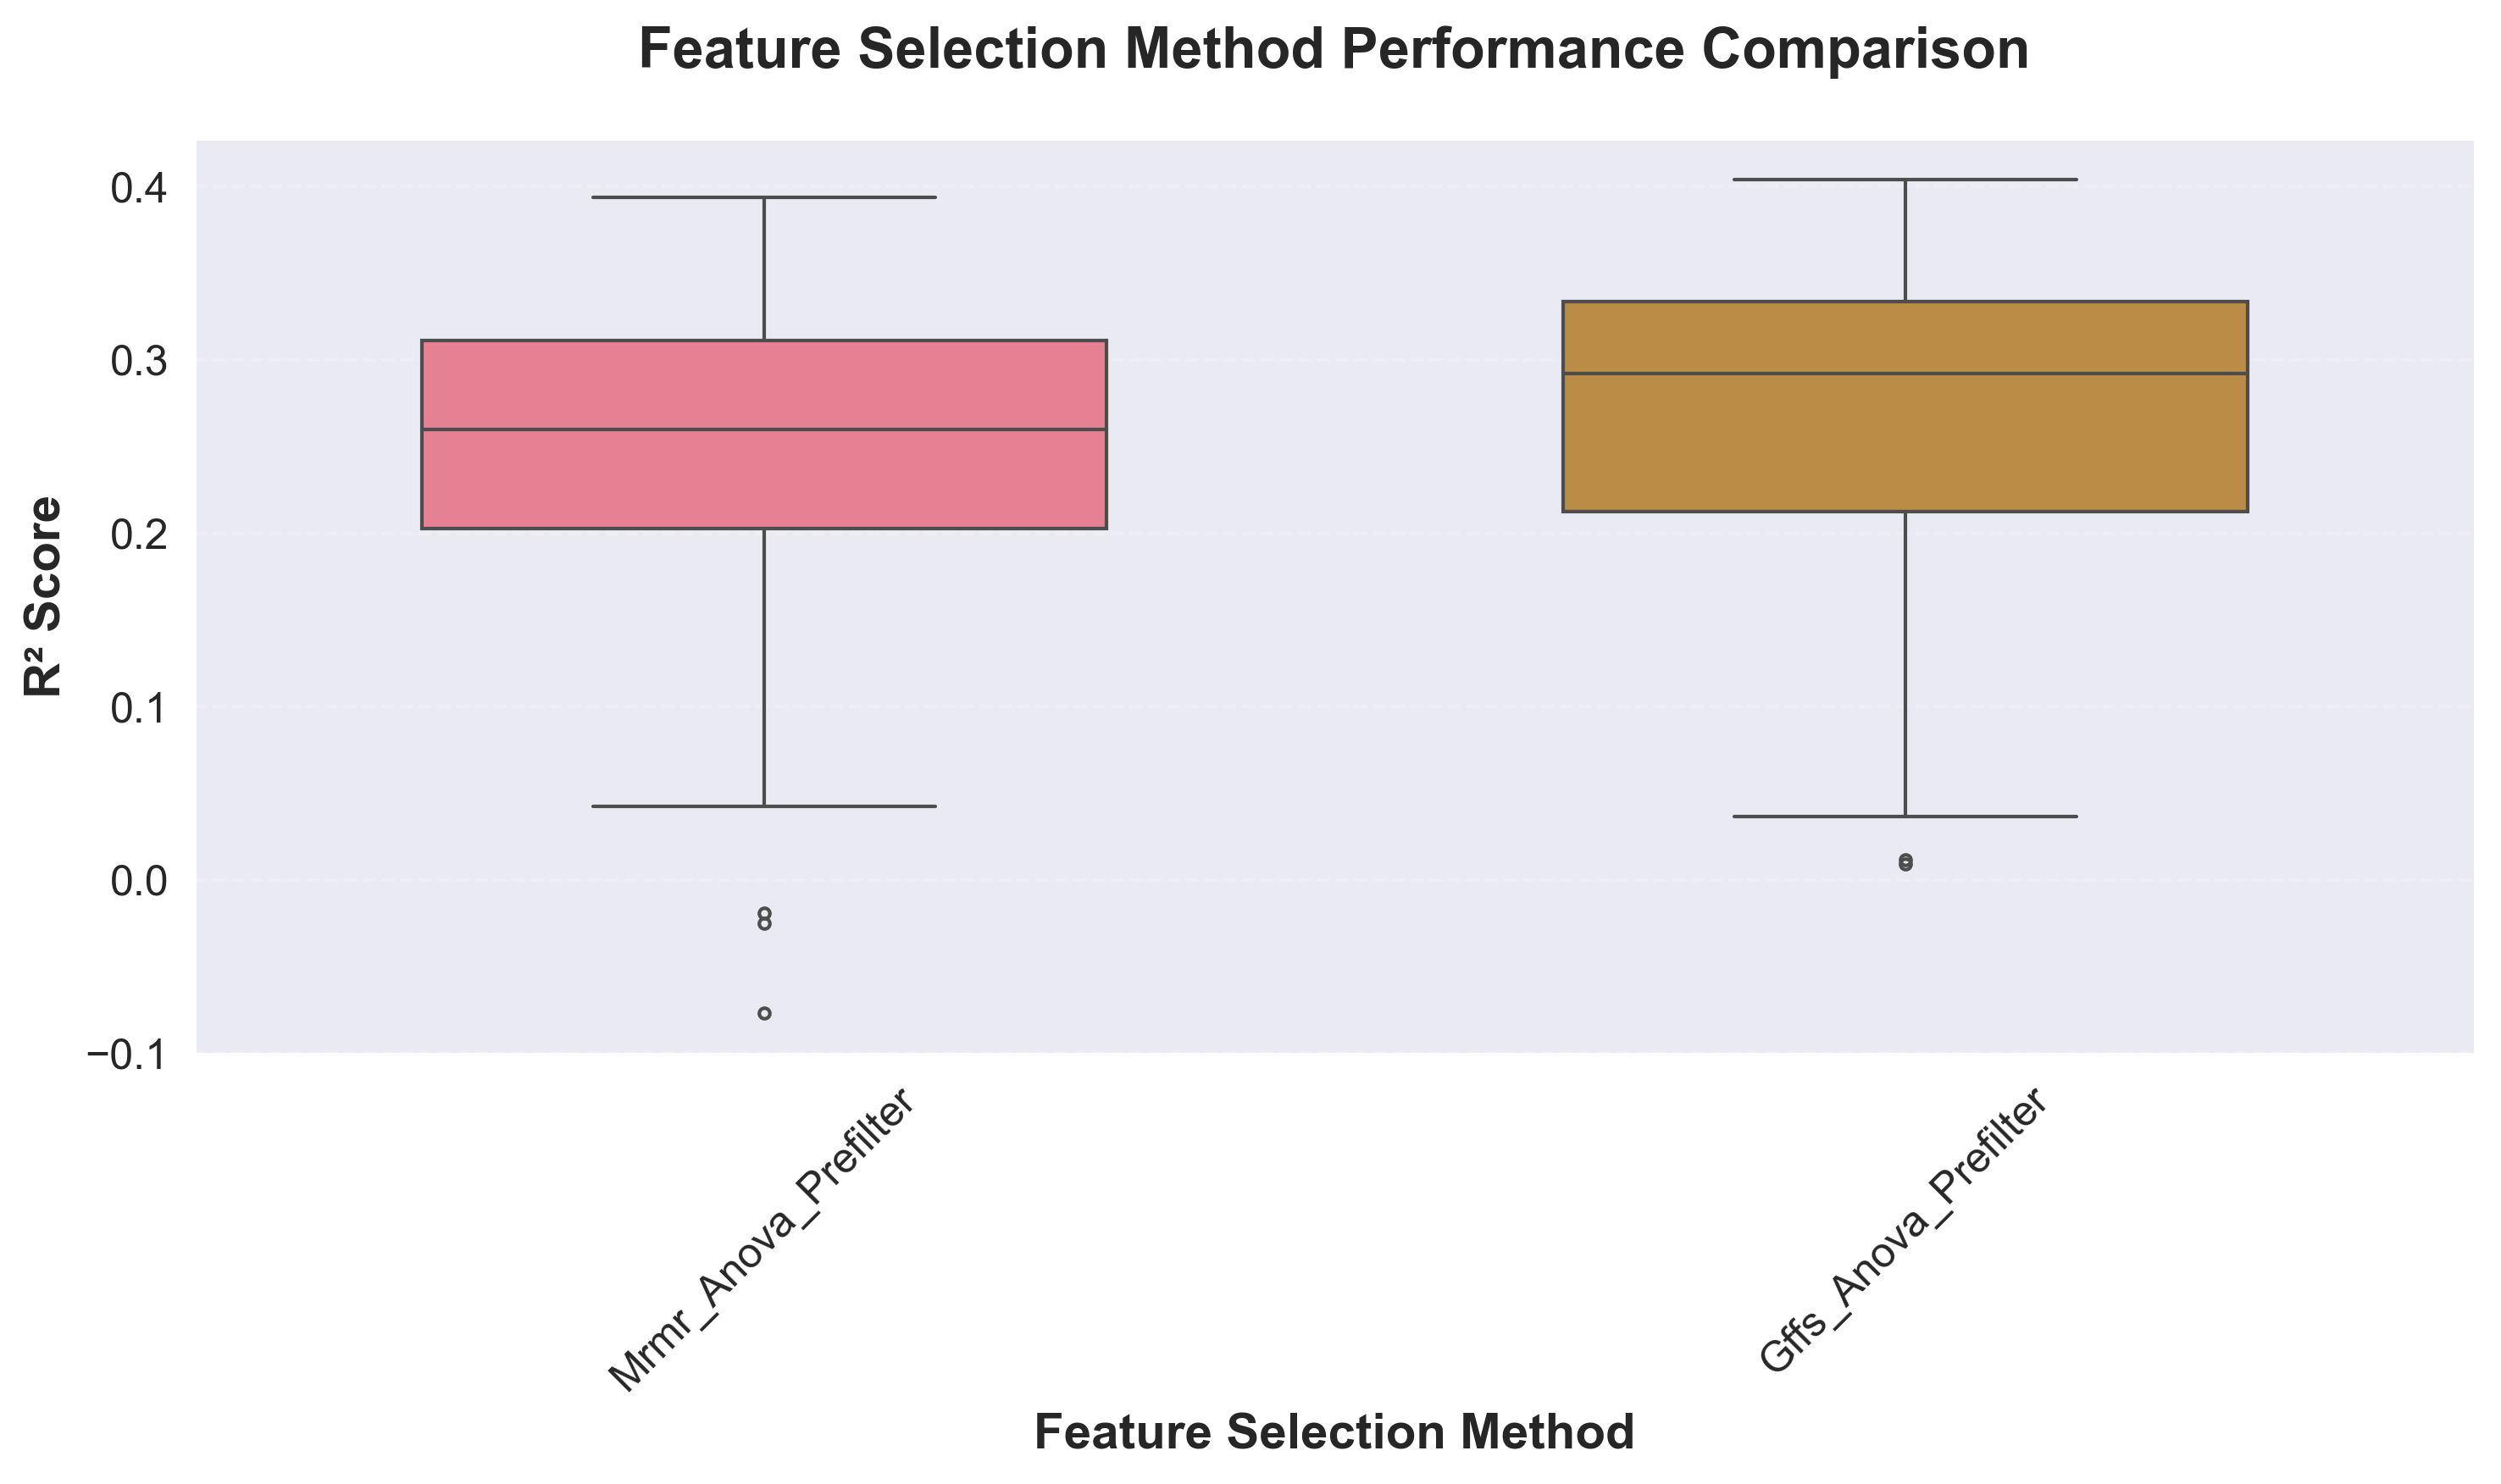

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Create publication-quality box plot comparing methods across all feature sizes and models
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Centralized color and marker mapping system for consistent visualization
def get_consistent_color_mapping(methods):
    """Create consistent color mapping for methods across all plots"""
    # Standard color palette for common methods
    standard_colors = {
        'anova': '#1f77b4',  # Blue
        'mrmr': '#ff7f0e',   # Orange
        'mutual': '#2ca02c', # Green
        'random': '#d62728'  # Red
    }
    
    # Extended palette for additional methods
    extended_palette = sns.color_palette("husl", max(8, len(methods)))
    
    color_mapping = {}
    for i, method in enumerate(methods):
        if method in standard_colors:
            color_mapping[method] = standard_colors[method]
        else:
            # Assign from extended palette for new methods
            color_mapping[method] = extended_palette[i % len(extended_palette)]
    
    return color_mapping

def get_consistent_marker_mapping(methods):
    """Create consistent marker mapping for methods across all plots"""
    base_markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd']
    
    marker_mapping = {}
    for i, method in enumerate(methods):
        marker_mapping[method] = base_markers[i % len(base_markers)]
    
    return marker_mapping

def get_dynamic_subplot_layout(n_items, max_cols=3):
    """Calculate optimal subplot layout based on number of items"""
    if n_items <= max_cols:
        return 1, n_items
    else:
        rows = (n_items + max_cols - 1) // max_cols  # Ceiling division
        return rows, max_cols

# Generate consistent color and marker mappings based on available methods
color_mapping = get_consistent_color_mapping(available_methods)
marker_mapping = get_consistent_marker_mapping(available_methods)

# Create palette list for seaborn in the correct order
palette = [color_mapping[method] for method in available_methods]

sns.boxplot(data=df_benchmark, x='method', y='model_performance', 
            order=available_methods,
            palette=palette, width=0.6, fliersize=3)
plt.title('Feature Selection Method Performance Comparison', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=14, fontweight='bold')
plt.xticks(ticks=range(len(available_methods)), 
           labels=[method_labels[m] for m in available_methods],
           rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig(f"{file_save_path}method_comparison_boxplot_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

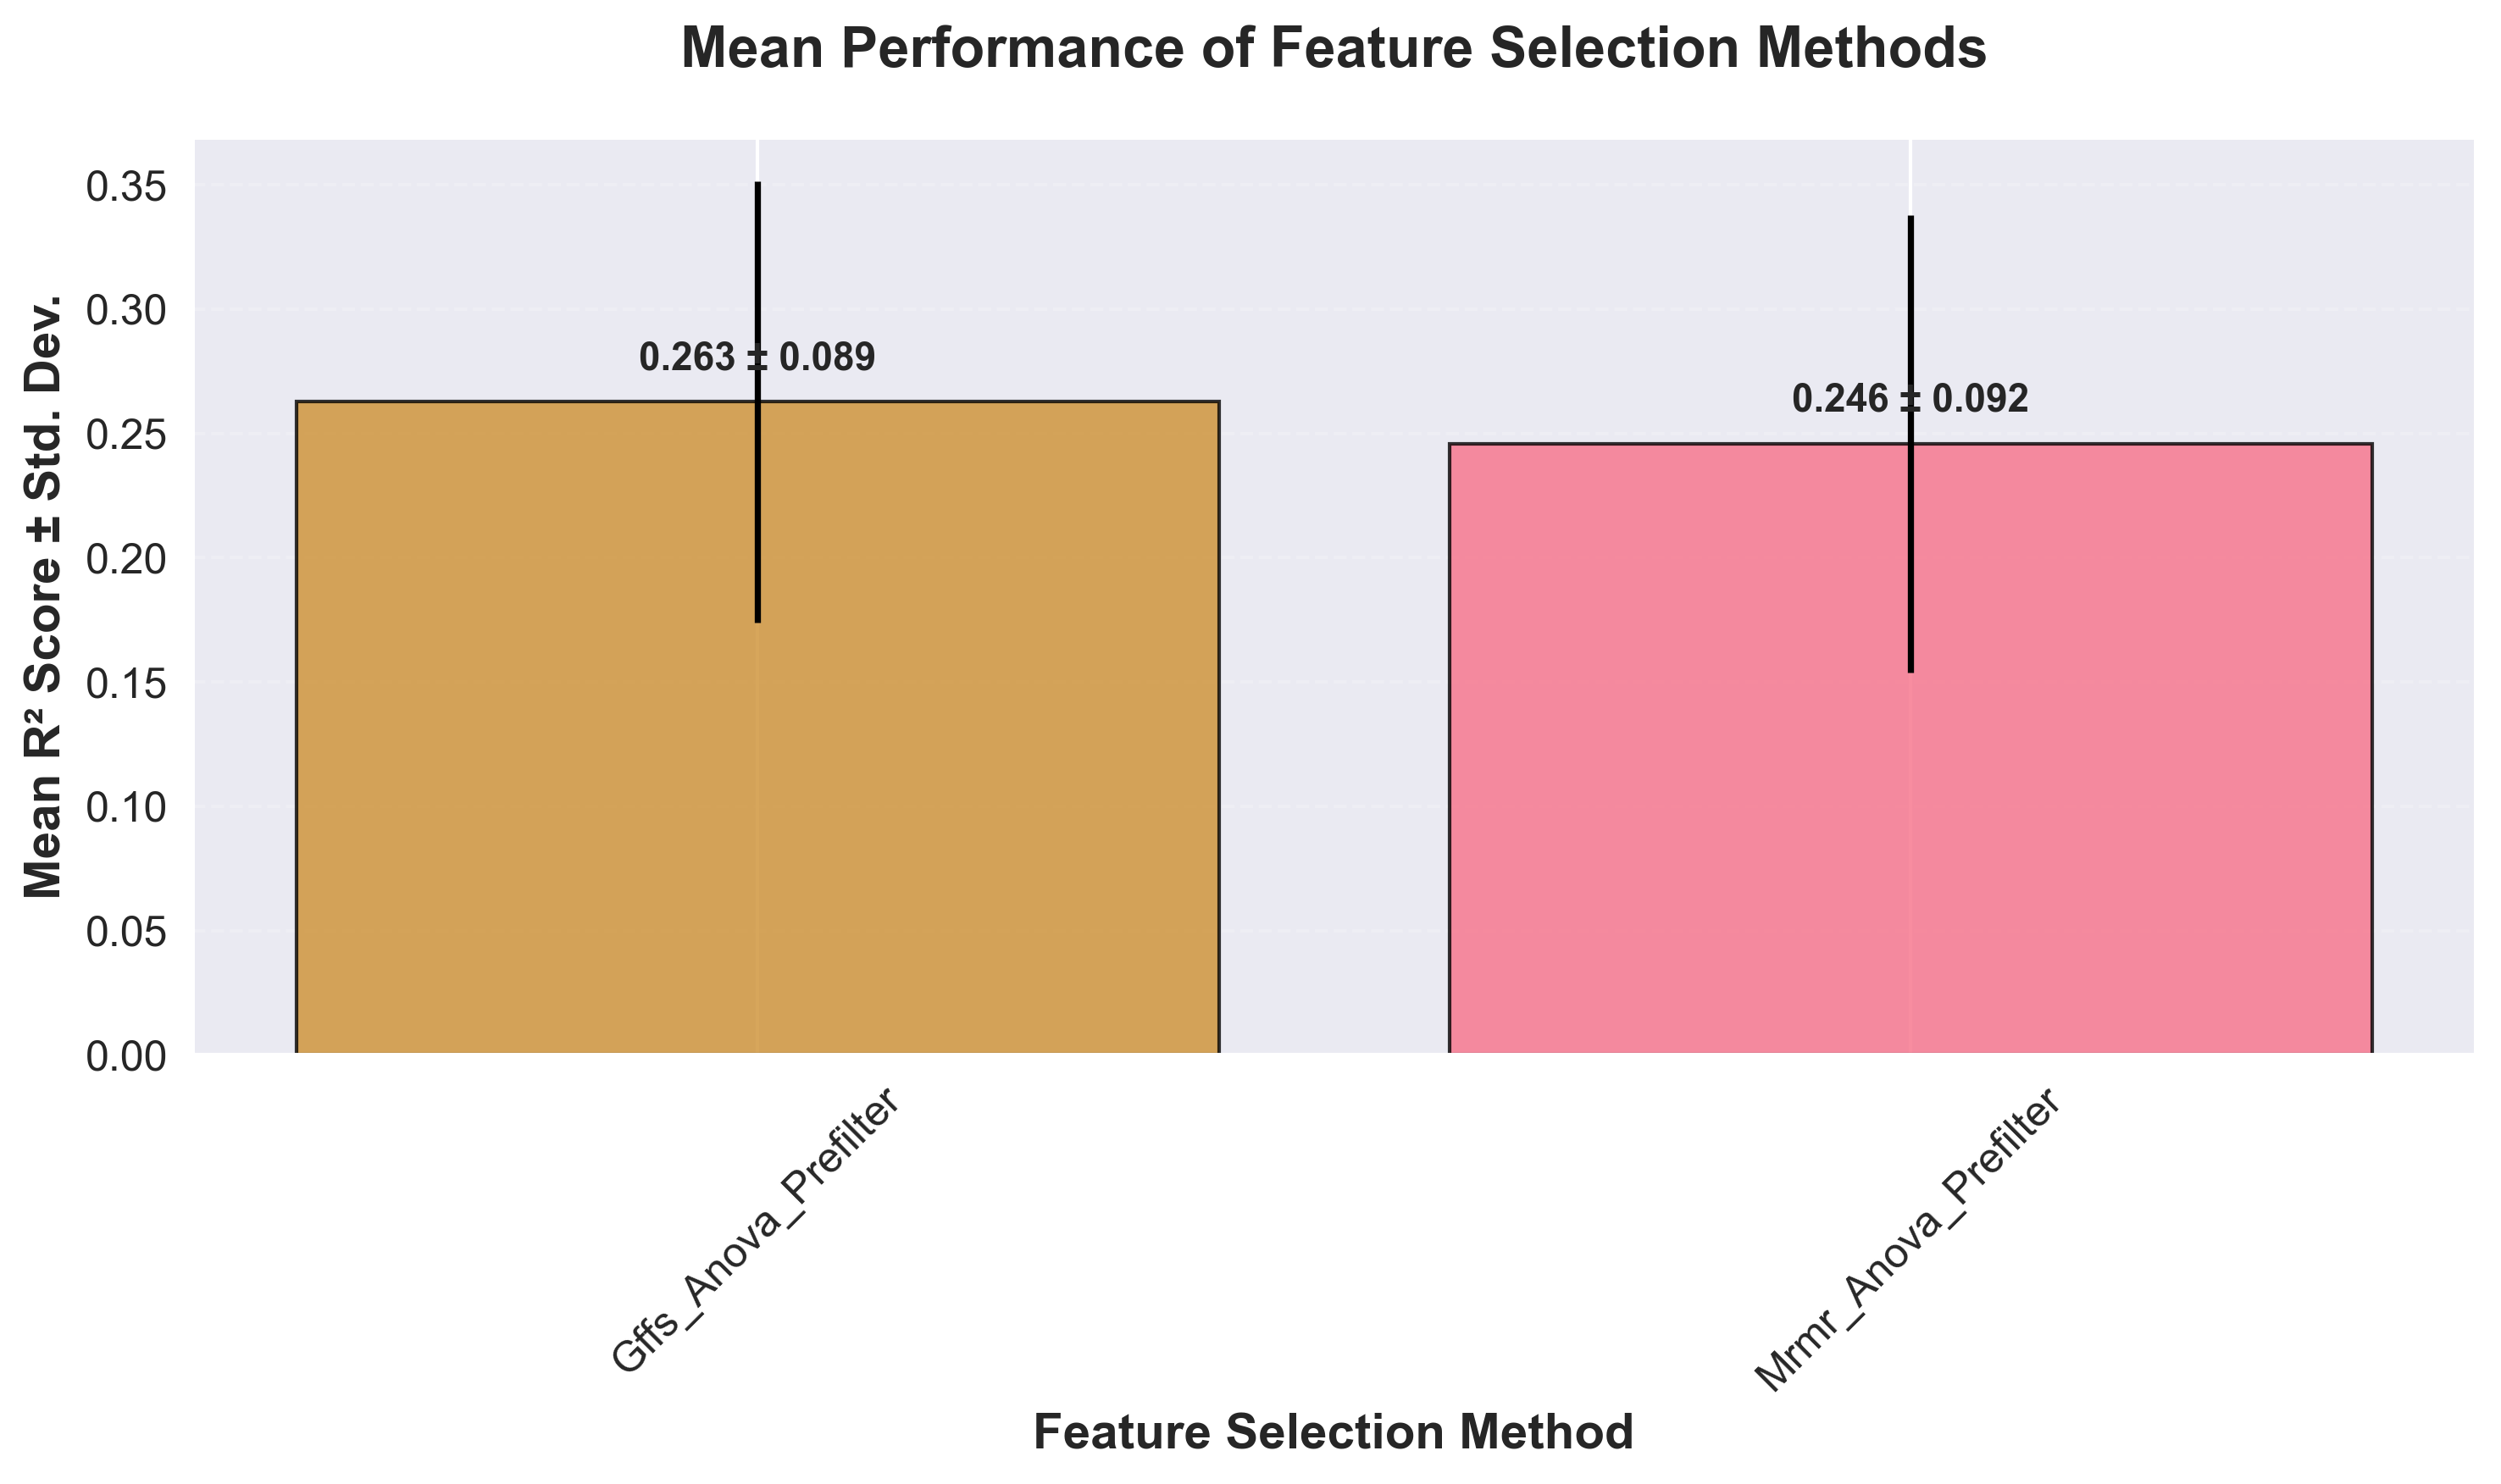

In [44]:
# Calculate mean and standard deviation for each method
method_stats = df_benchmark.groupby('method')['model_performance'].agg(['mean', 'std', 'count']).reset_index()

# Create publication-quality bar plot with error bars
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Use consistent colors for bar plot
bar_colors = [color_mapping[method] for method in method_stats['method']]
bars = plt.bar(range(len(method_stats)), method_stats['mean'], 
               yerr=method_stats['std'], capsize=8, alpha=0.8,
               color=bar_colors, edgecolor='black', linewidth=1)

plt.title('Mean Performance of Feature Selection Methods', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score ± Std. Dev.', fontsize=14, fontweight='bold')
plt.xticks(ticks=range(len(method_stats)), 
           labels=[method_labels.get(m, m) for m in method_stats['method']],
           rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on bars with improved formatting
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f} ± {method_stats.iloc[i]["std"]:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig(f"{file_save_path}method_performance_bar_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# Create comprehensive statistical summary
summary_table = df_benchmark.groupby('method')['model_performance'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('25%', lambda x: x.quantile(0.25)),
    ('median', 'median'),
    ('75%', lambda x: x.quantile(0.75)),
    ('max', 'max')
]).round(4)

save_and_print("Performance Statistics by Feature Selection Method:", print_report_file, level="section")
save_and_print(summary_table.to_string(), print_report_file, level="info")

Performance Statistics by Feature Selection Method:
                      count    mean     std     min     25%  median     75%     max
method                                                                             
gffs_anova_prefilter    120  0.2627  0.0888  0.0092  0.2123  0.2921  0.3336  0.4040
mrmr_anova_prefilter    120  0.2459  0.0920 -0.0770  0.2028  0.2598  0.3114  0.3938


'                      count    mean     std     min     25%  median     75%     max\nmethod                                                                             \ngffs_anova_prefilter    120  0.2627  0.0888  0.0092  0.2123  0.2921  0.3336  0.4040\nmrmr_anova_prefilter    120  0.2459  0.0920 -0.0770  0.2028  0.2598  0.3114  0.3938'

### Performance vs. Feature Set Size (k value)

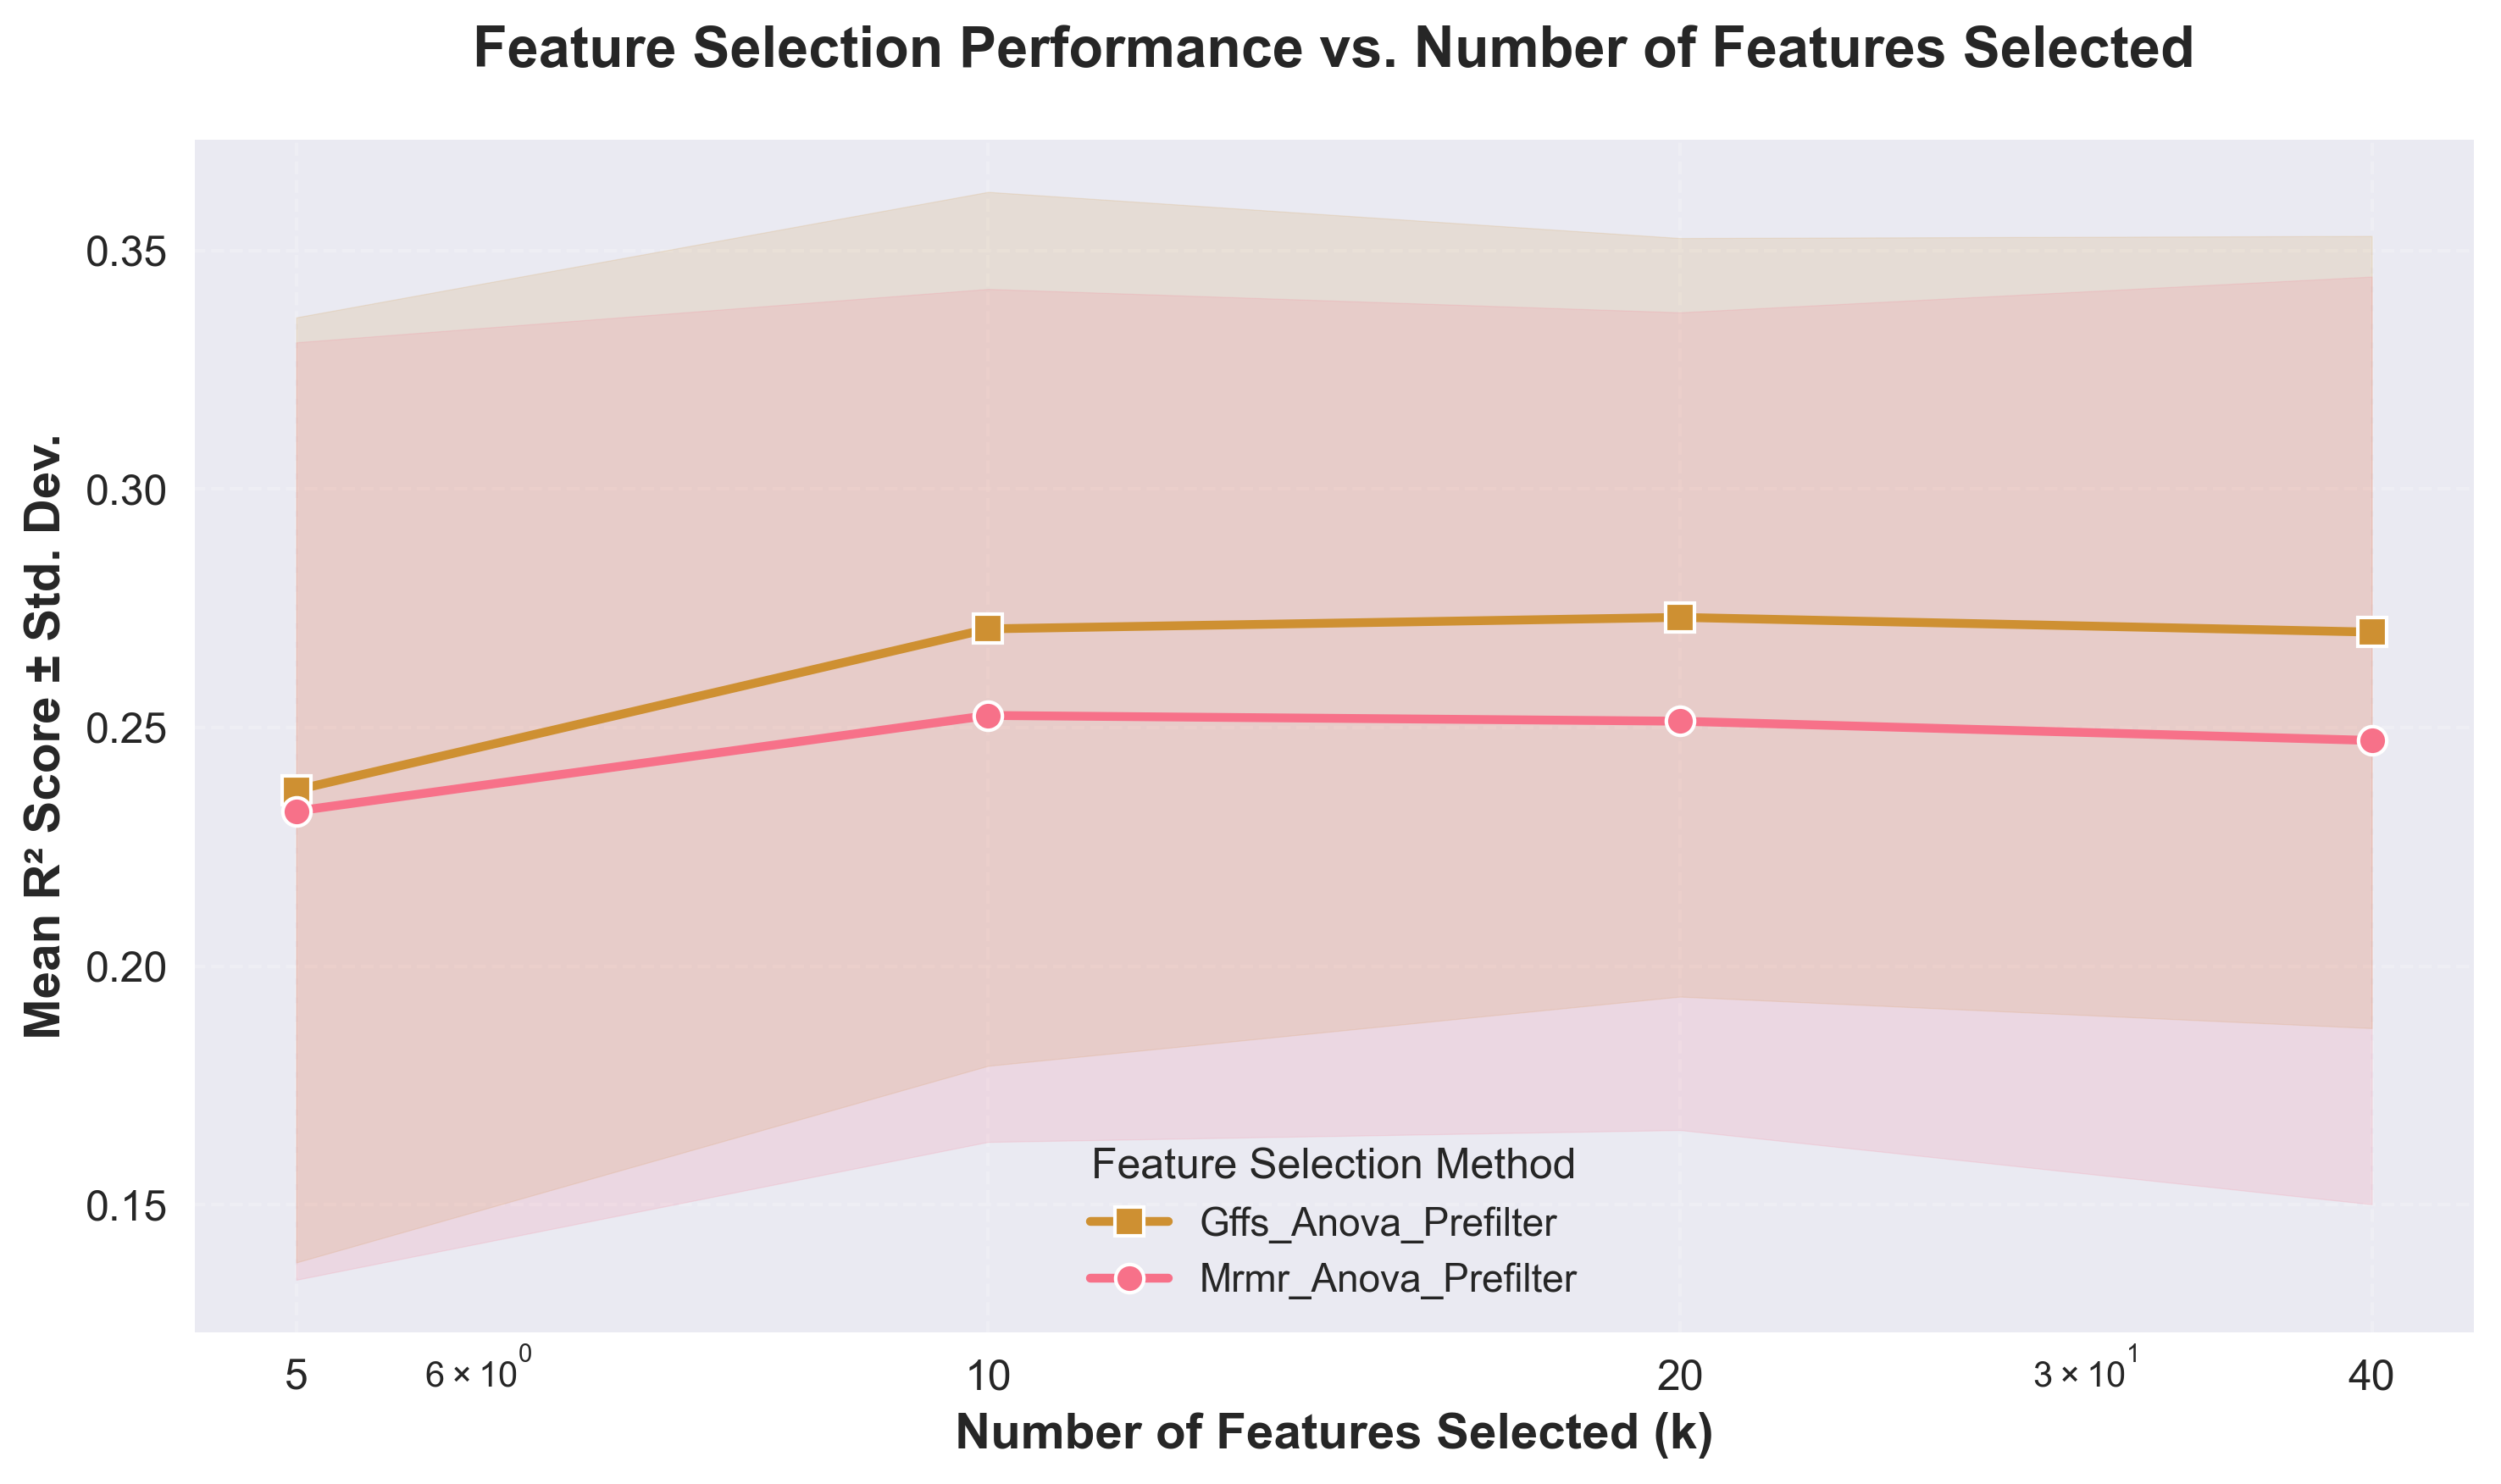

In [46]:
# Derive feature_set_sizes from the dataframe to handle different runs
feature_set_sizes_viz = sorted(df_benchmark['k_value'].unique())
# Use actual k-values from data for consistency
feature_set_sizes = feature_set_sizes_viz

# Calculate mean and standard deviation for each method and k value
k_performance_stats = df_benchmark.groupby(['method', 'k_value'])['model_performance'].agg(['mean', 'std', 'count']).reset_index()

# Create publication-quality line plot with standard deviation bands
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Plot each method with error bands using consistent colors and markers
for i, method in enumerate(k_performance_stats['method'].unique()):
    method_data = k_performance_stats[k_performance_stats['method'] == method]
    
    # Sort by k_value to ensure proper line plotting
    method_data = method_data.sort_values('k_value')
    
    # Plot the mean line
    plt.plot(method_data['k_value'], method_data['mean'], 
             marker=marker_mapping[method], linewidth=2.5, markersize=8, 
             color=color_mapping[method], markeredgecolor='white', markeredgewidth=1,
             label=method_labels.get(method, method))
    
    # Add standard deviation bands (shaded area)
    plt.fill_between(method_data['k_value'], 
                     method_data['mean'] - method_data['std'],
                     method_data['mean'] + method_data['std'],
                     alpha=0.15, color=color_mapping[method])

plt.title('Feature Selection Performance vs. Number of Features Selected', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score ± Std. Dev.', fontsize=14, fontweight='bold')
plt.xscale('log')  # Use log scale for better visualization of wide k range
plt.xticks(feature_set_sizes_viz, feature_set_sizes_viz, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Feature Selection Method', fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}performance_vs_k_value_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 5400x1800 with 0 Axes>

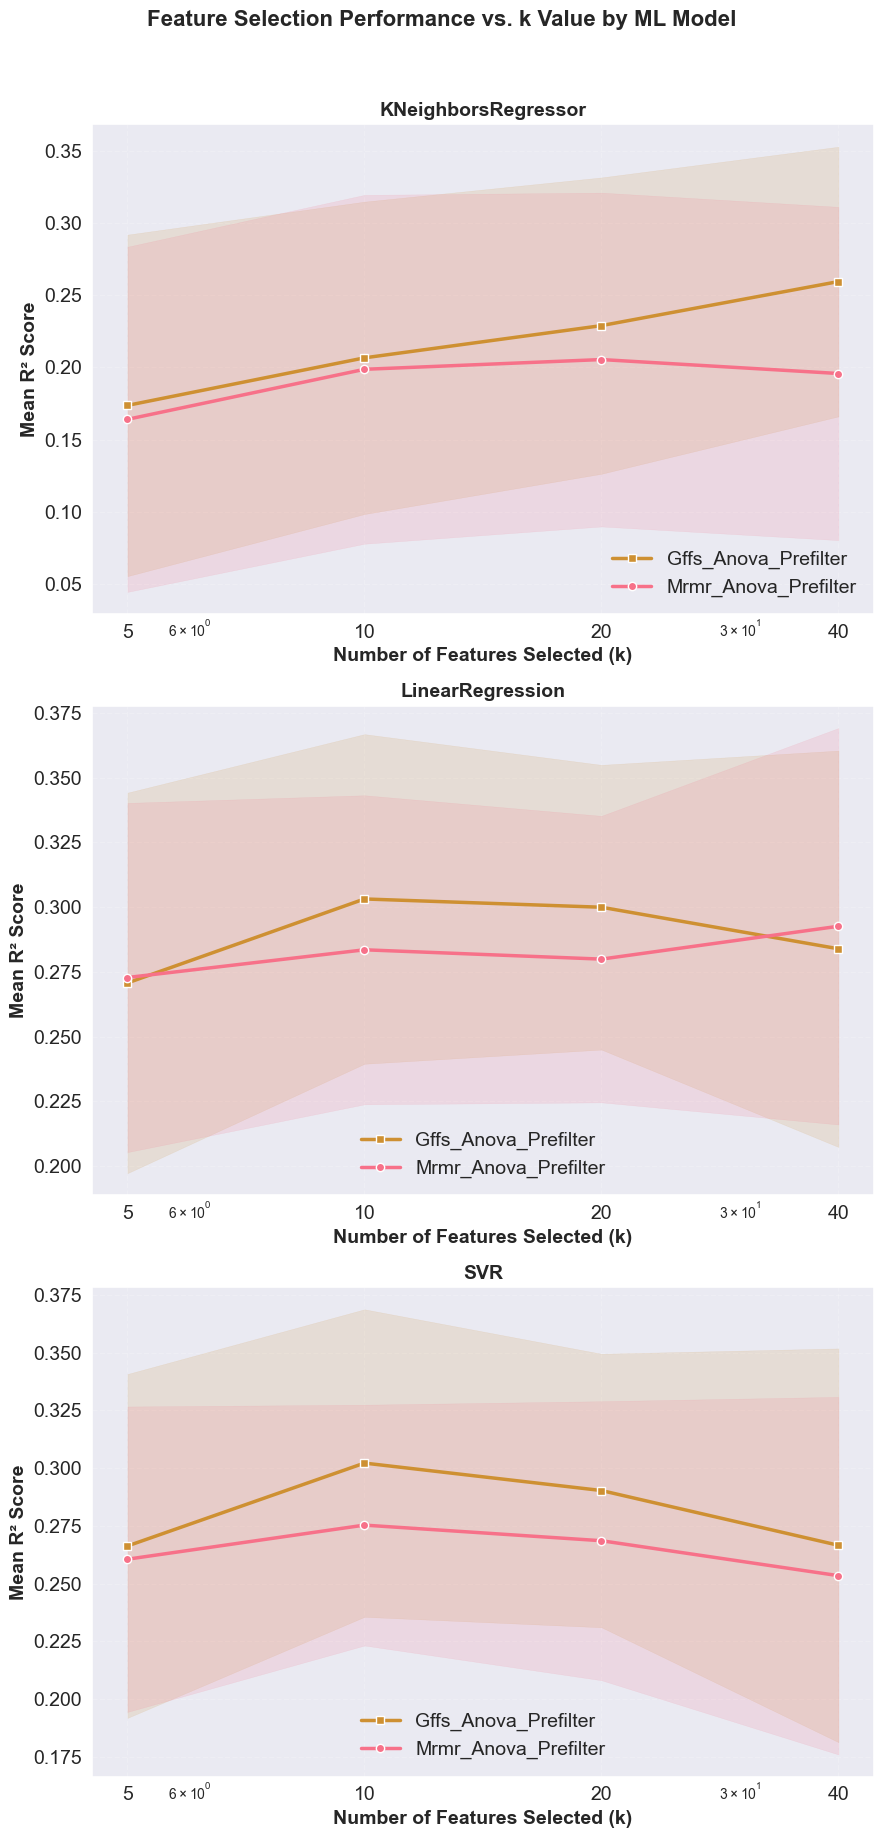

In [47]:
# Create publication-quality faceted line plots by model type
plt.figure(figsize=(18, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Calculate stats by method, k_value, and model_name
model_k_stats = df_benchmark.groupby(['method', 'k_value', 'model_name'])['model_performance'].agg(['mean', 'std']).reset_index()

# Create subplots for each model
models = ['KNeighborsRegressor', 'LinearRegression', 'SVR']
fig, axes = plt.subplots(3, 1, figsize=(9, 18))

# Use consistent colors and markers for faceted plots
for i, model in enumerate(models):
    model_data = model_k_stats[model_k_stats['model_name'] == model]
    
    for j, method in enumerate(model_data['method'].unique()):
        method_model_data = model_data[model_data['method'] == method].sort_values('k_value')
        
        axes[i].plot(method_model_data['k_value'], method_model_data['mean'], 
                     marker=marker_mapping[method], linewidth=2.5, markersize=6,
                     color=color_mapping[method], markeredgecolor='white', markeredgewidth=1,
                     label=method_labels.get(method, method))
        
        axes[i].fill_between(method_model_data['k_value'],
                            method_model_data['mean'] - method_model_data['std'],
                            method_model_data['mean'] + method_model_data['std'],
                            alpha=0.15, color=color_mapping[method])
    
    axes[i].set_title(f'{model}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Mean R² Score', fontsize=14, fontweight='bold')
    axes[i].set_xscale('log')
    axes[i].set_xticks(feature_set_sizes_viz, feature_set_sizes_viz, fontsize=14)
    axes[i].tick_params(axis='y', labelsize=14)
    axes[i].grid(True, alpha=0.2, linestyle='--')
    axes[i].legend(fontsize=14, framealpha=0.9)

plt.suptitle('Feature Selection Performance vs. k Value by ML Model', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{file_save_path}performance_vs_k_by_model_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# Statistical analysis of k value effect
save_and_print("Performance Trend Analysis by k Value:", print_report_file, level="section")
for method in df_benchmark['method'].unique():
    method_data = df_benchmark[df_benchmark['method'] == method]
    
    # Calculate correlation between k_value and performance
    correlation = method_data['k_value'].corr(method_data['model_performance'])
    
    # Calculate performance change from smallest to largest k
    k_min_perf = method_data[method_data['k_value'] == 10]['model_performance'].mean()
    k_max_perf = method_data[method_data['k_value'] == 1280]['model_performance'].mean()
    performance_change = k_max_perf - k_min_perf
    
    save_and_print(f"\n{method_labels.get(method, method)}:", print_report_file, level="subsection")
    save_and_print(f"  Correlation (k vs performance): {correlation:.4f}", print_report_file, level="info")
    save_and_print(f"  Performance change (k=10 to k=1280): {performance_change:.4f}", print_report_file, level="info")
    save_and_print(f"  Optimal k range: {method_data.groupby('k_value')['model_performance'].mean().idxmax()} features", print_report_file, level="info")

Performance Trend Analysis by k Value:

Mrmr_Anova_Prefilter:
  Correlation (k vs performance): 0.0331
  Performance change (k=10 to k=1280): nan
  Optimal k range: 10 features

Gffs_Anova_Prefilter:
  Correlation (k vs performance): 0.0956
  Performance change (k=10 to k=1280): nan
  Optimal k range: 20 features


### Performance vs. Feature Set Size (k value) - Excluding Specific k Values

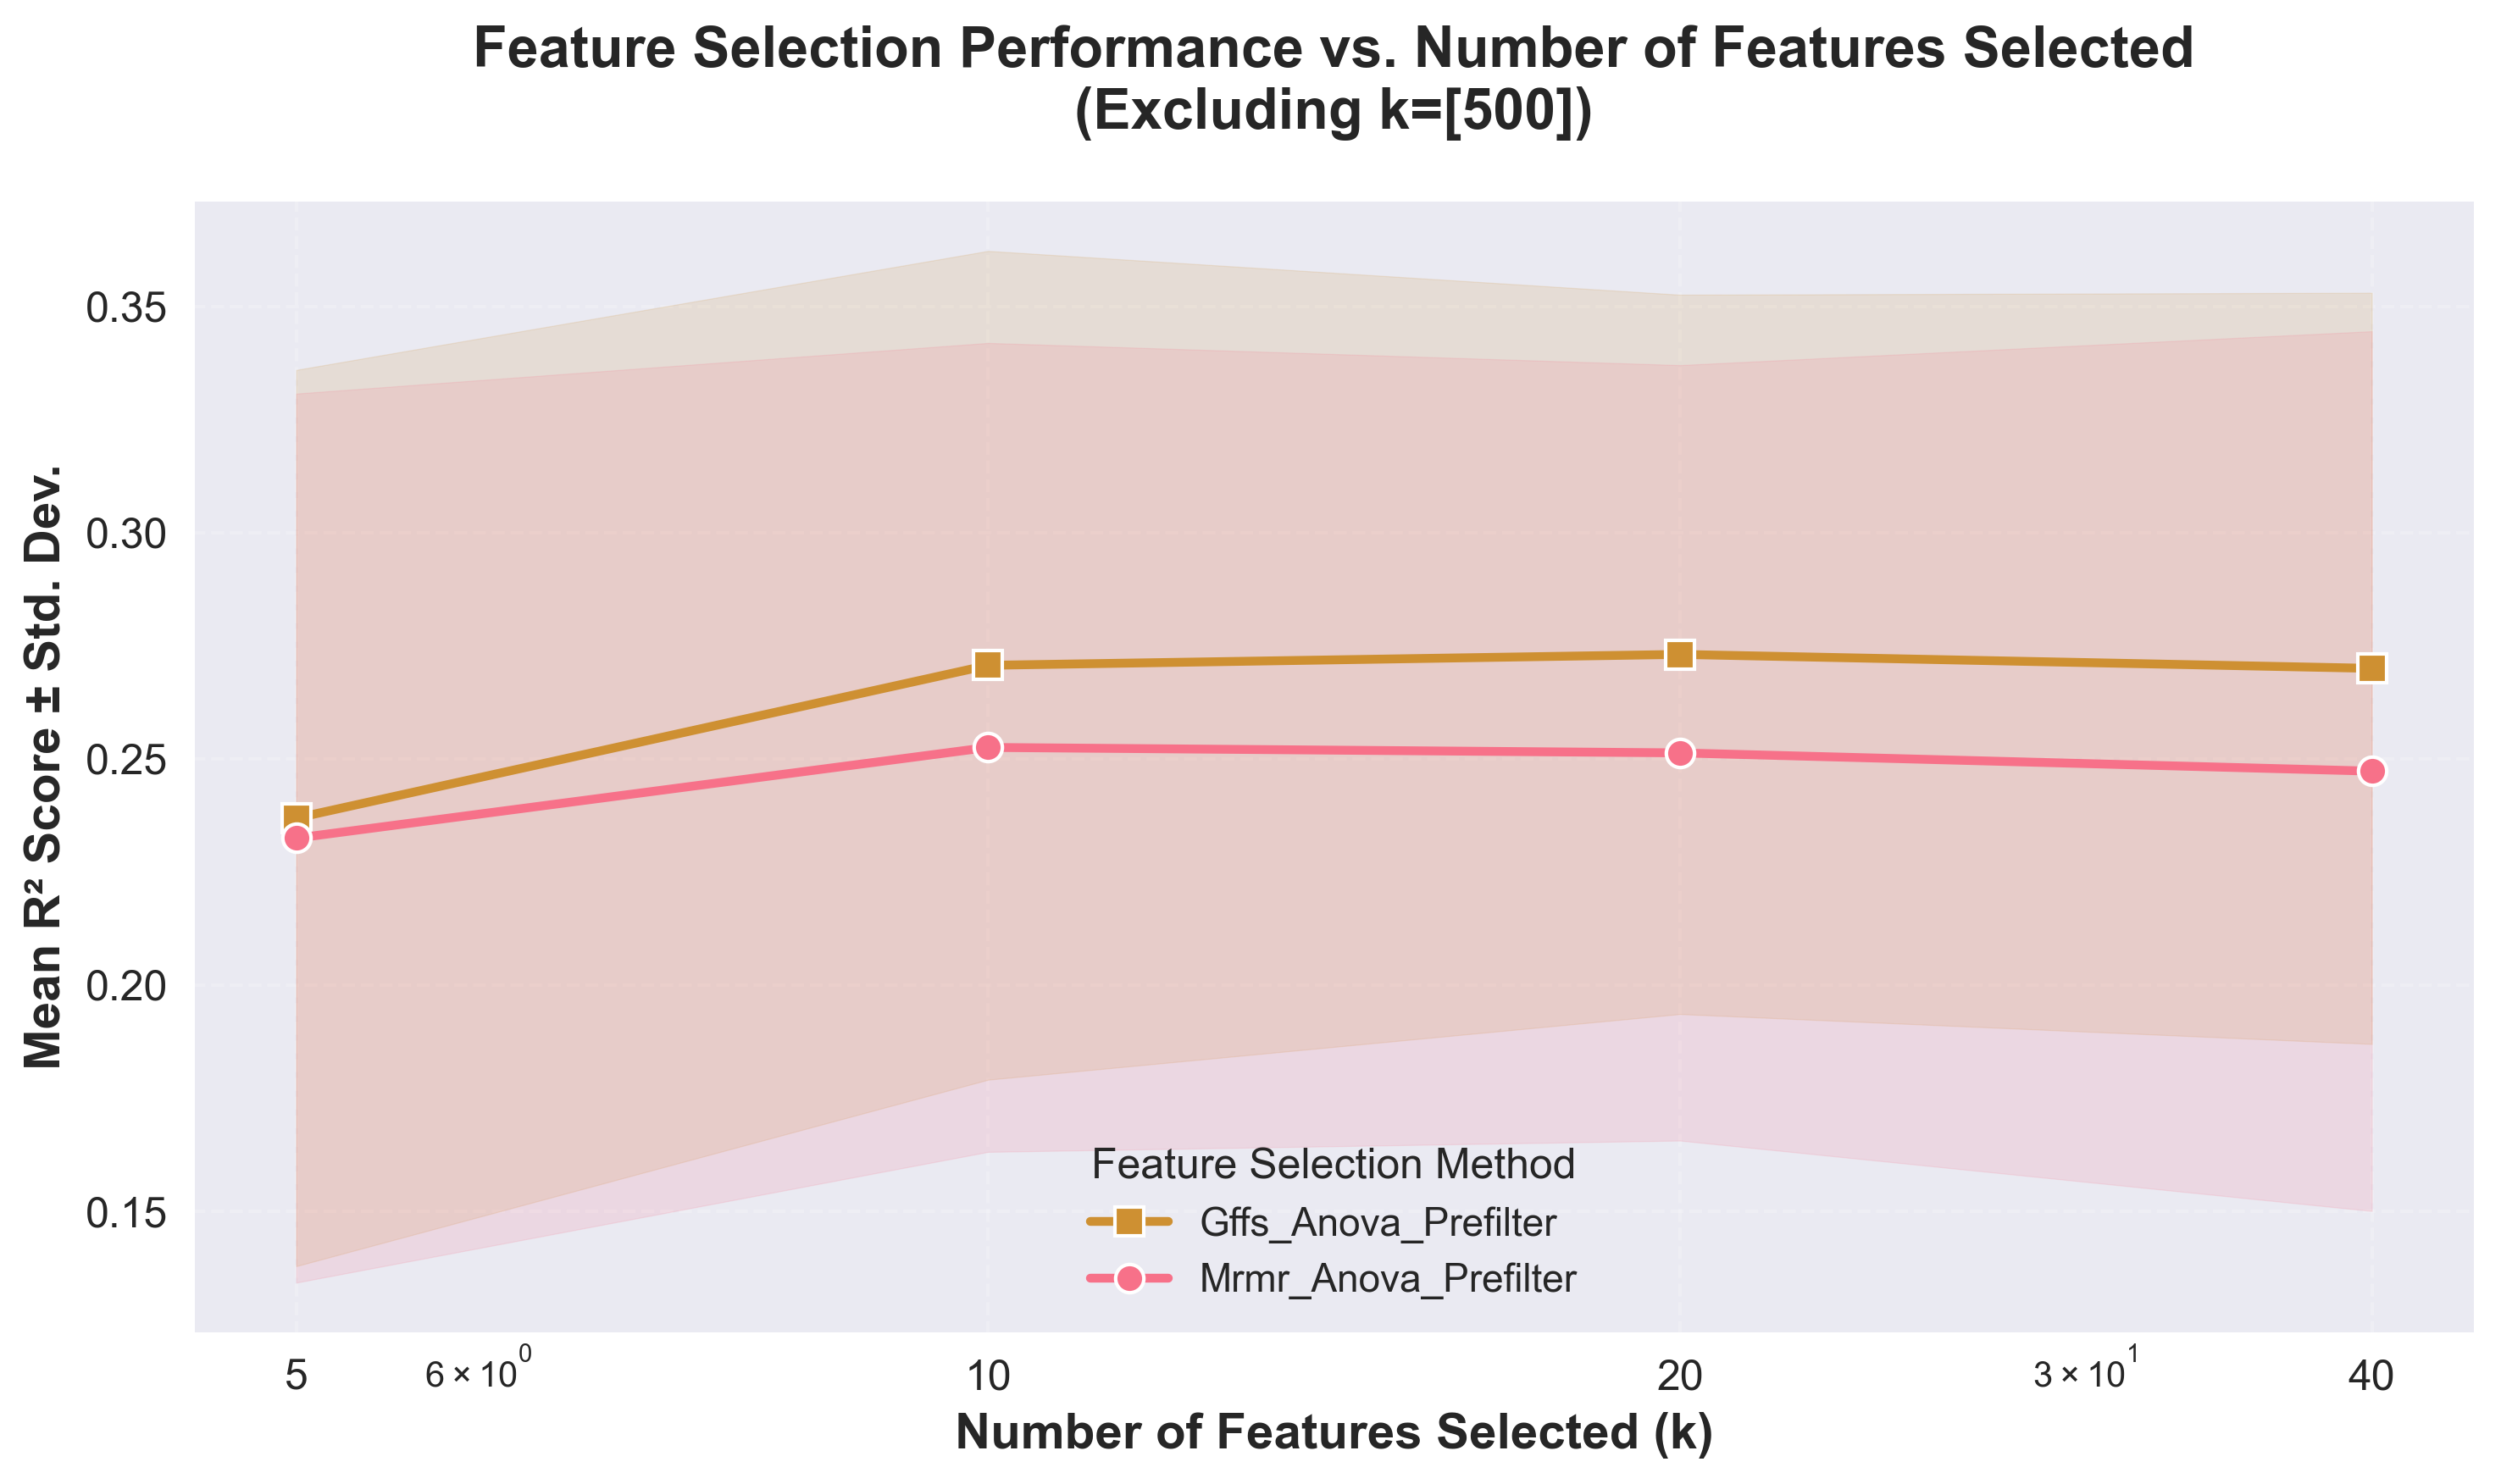

Created visualization excluding k values: [500]
Remaining k values in visualization: [np.int64(5), np.int64(10), np.int64(20), np.int64(40)]


'Remaining k values in visualization: [np.int64(5), np.int64(10), np.int64(20), np.int64(40)]'

In [49]:
# Create visualization excluding specific k values (e.g., k=500)
k_values_to_exclude = [500]  # Add any k values you want to exclude here

# Filter dataframe to exclude specific k values
df_filtered = df_benchmark[~df_benchmark['k_value'].isin(k_values_to_exclude)]

# Derive feature_set_sizes from the filtered dataframe
feature_set_sizes_filtered = sorted(df_filtered['k_value'].unique())

# Calculate mean and standard deviation for each method and k value
k_performance_stats_filtered = df_filtered.groupby(['method', 'k_value'])['model_performance'].agg(['mean', 'std', 'count']).reset_index()

# Create publication-quality line plot with standard deviation bands (excluding specific k values)
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Use consistent colors and markers for filtered plot
for i, method in enumerate(k_performance_stats_filtered['method'].unique()):
    method_data = k_performance_stats_filtered[k_performance_stats_filtered['method'] == method]
    
    # Sort by k_value to ensure proper line plotting
    method_data = method_data.sort_values('k_value')
    
    # Plot the mean line
    plt.plot(method_data['k_value'], method_data['mean'], 
             marker=marker_mapping[method], linewidth=2.5, markersize=8, 
             color=color_mapping[method], markeredgecolor='white', markeredgewidth=1,
             label=method_labels.get(method, method))
    
    # Add standard deviation bands (shaded area)
    plt.fill_between(method_data['k_value'], 
                     method_data['mean'] - method_data['std'],
                     method_data['mean'] + method_data['std'],
                     alpha=0.15, color=color_mapping[method])

plt.title(f'Feature Selection Performance vs. Number of Features Selected\n(Excluding k={k_values_to_exclude})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score ± Std. Dev.', fontsize=14, fontweight='bold')
plt.xscale('log')  # Use log scale for better visualization of wide k range
plt.xticks(feature_set_sizes_filtered, feature_set_sizes_filtered, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Feature Selection Method', fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}{exp_id}performance_vs_k_value_excluding_{'_'.join(map(str, k_values_to_exclude))}.png", dpi=300, bbox_inches='tight')
plt.show()

save_and_print(f"Created visualization excluding k values: {k_values_to_exclude}", print_report_file, level="info")
save_and_print(f"Remaining k values in visualization: {feature_set_sizes_filtered}", print_report_file, level="info")

### Performance vs. Feature Set Size (k value) - Without Standard Error Bars

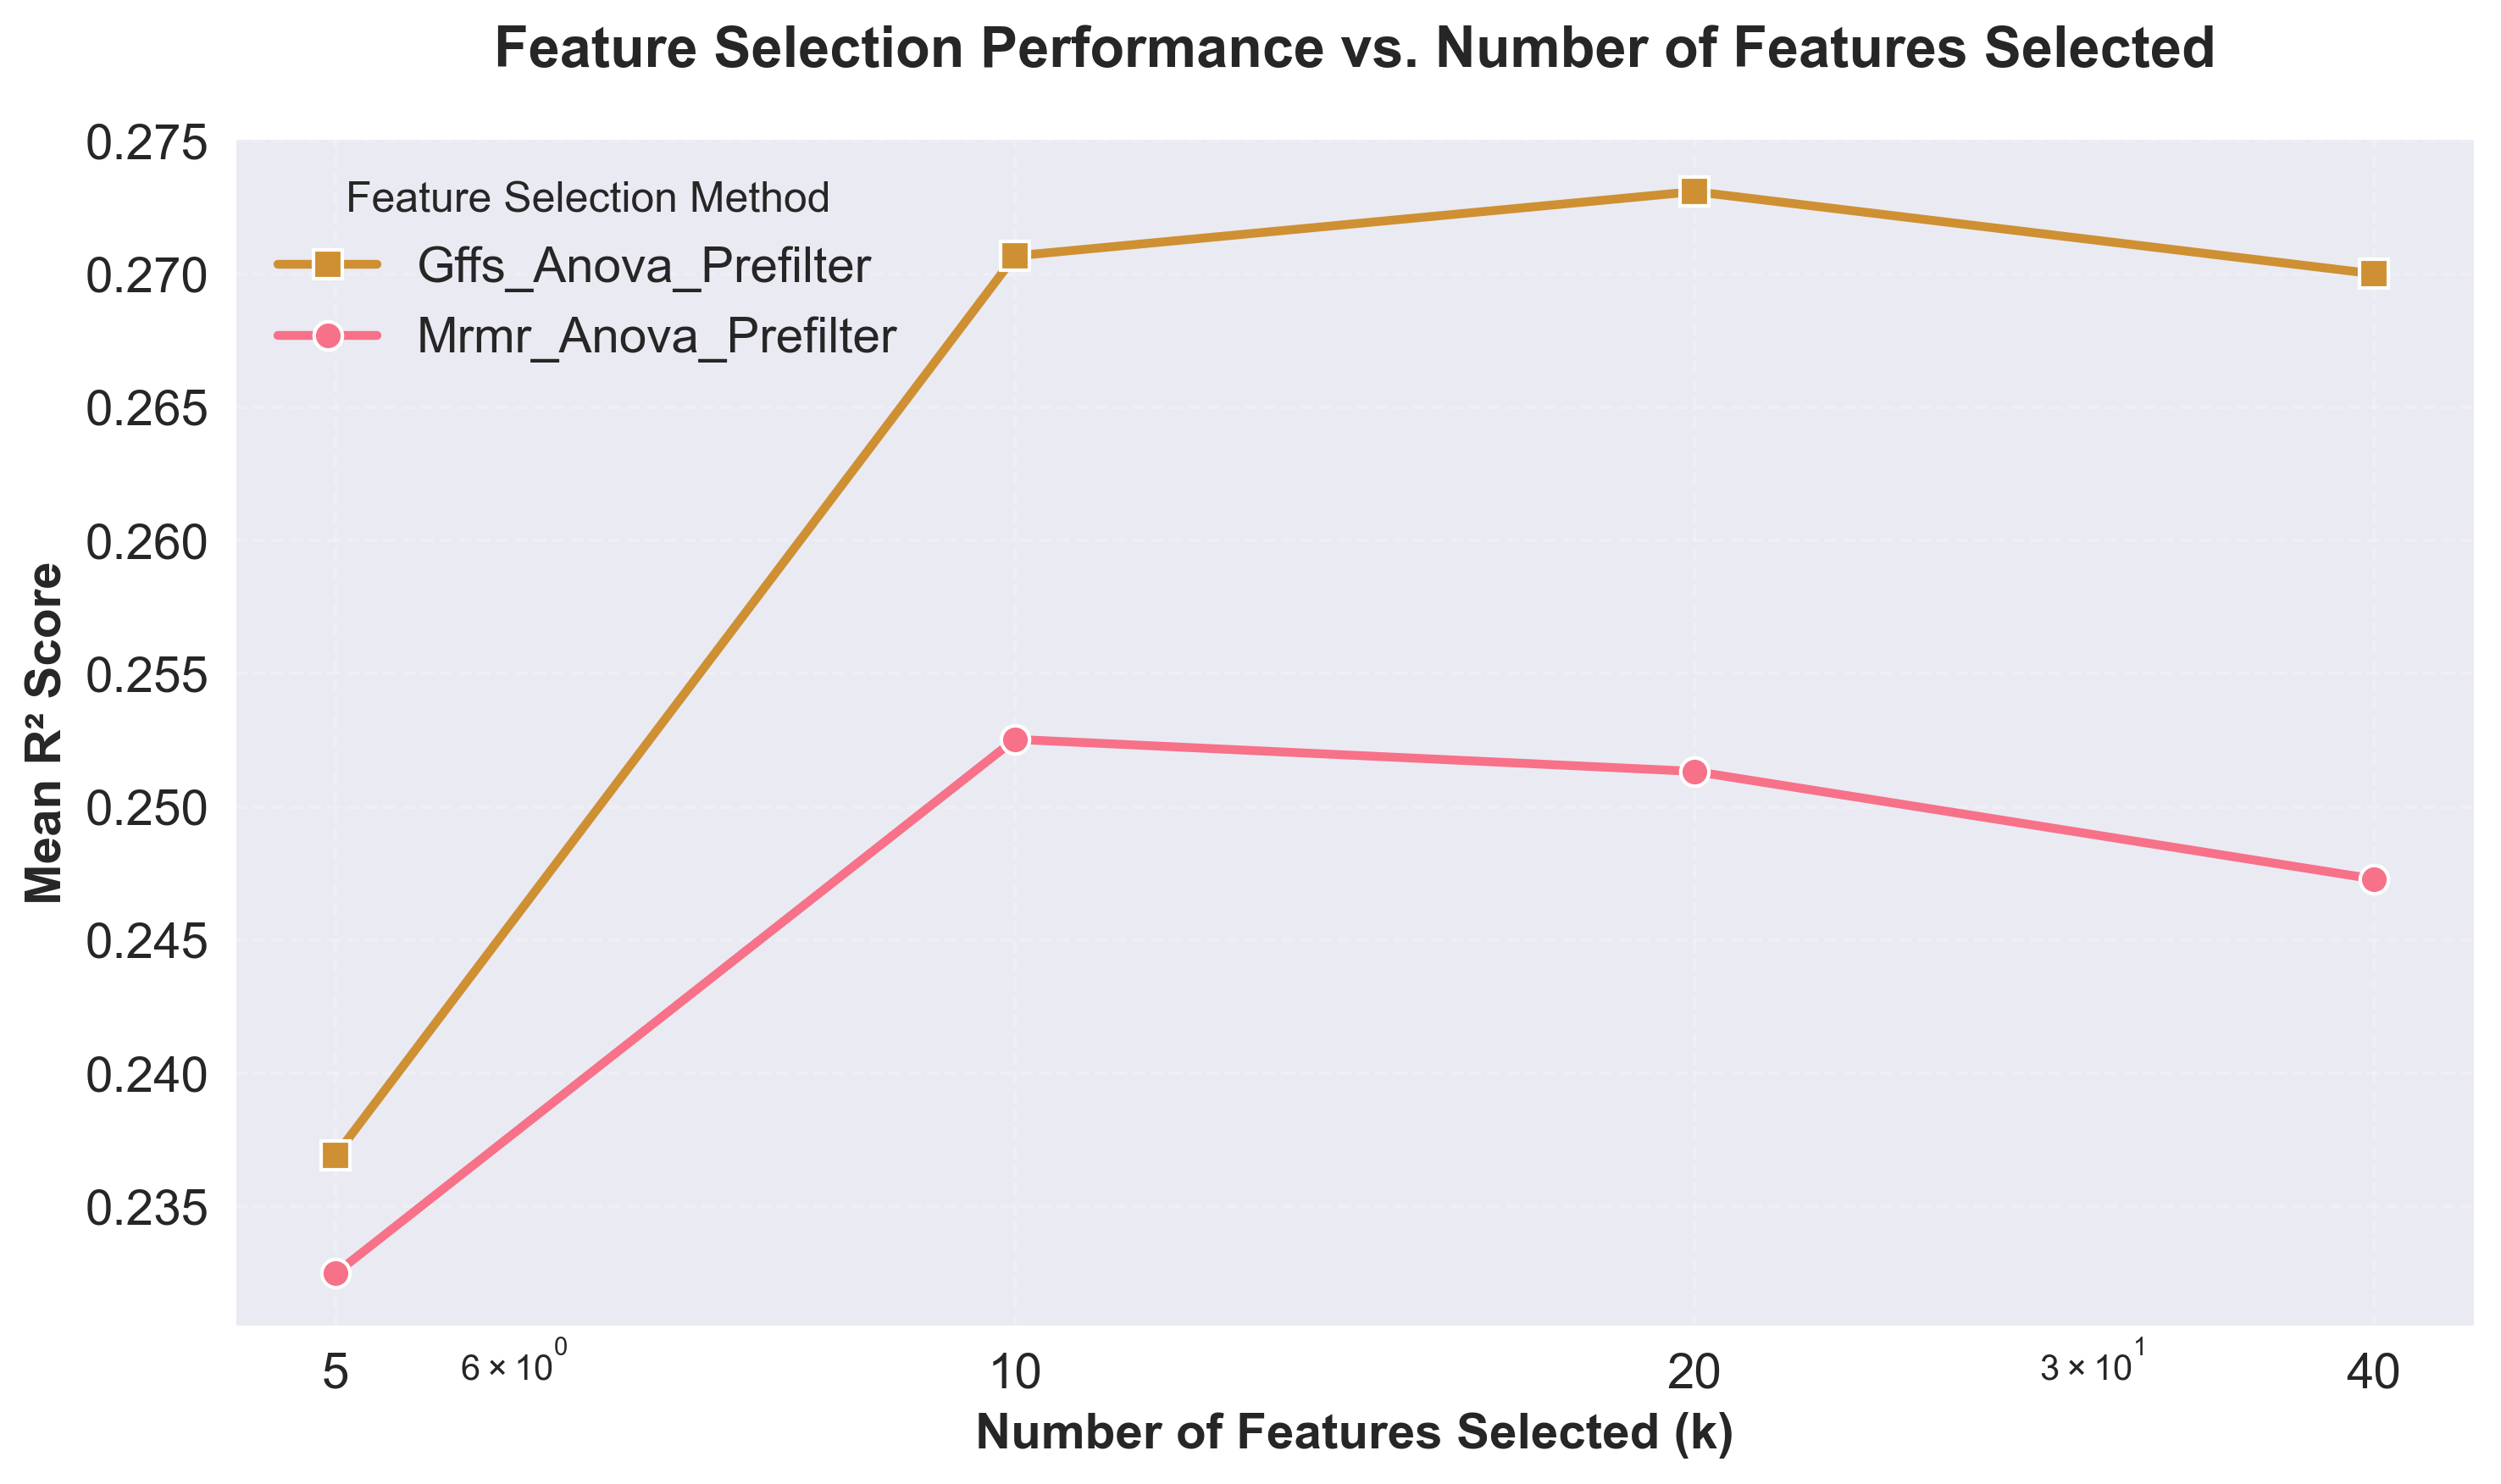

Created line plot without standard error bars


In [50]:
# Create line plot without standard error bars (cleaner visualization)
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Use consistent colors and markers for no-error-bars plot
for i, method in enumerate(k_performance_stats_filtered["method"].unique()):
    method_data = k_performance_stats_filtered[k_performance_stats_filtered["method"] == method]
    
    # Sort by k_value to ensure proper line plotting
    method_data = method_data.sort_values('k_value')
    
    # Plot the mean line only (no error bands)
    plt.plot(method_data['k_value'], method_data['mean'], 
             marker=marker_mapping[method], linewidth=2.5, markersize=8, 
             color=color_mapping[method], markeredgecolor='white', markeredgewidth=1,
             label=method_labels.get(method, method))

plt.title('Feature Selection Performance vs. Number of Features Selected', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score', fontsize=14, fontweight='bold')
plt.xscale('log')  # Use log scale for better visualization of wide k range
plt.xticks(feature_set_sizes_viz, feature_set_sizes_viz, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Feature Selection Method', fontsize=14, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}performance_vs_k_value_no_error_bars_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

print("Created line plot without standard error bars")

## Feature Selection Analysis

### Feature Selection Frequency Analysis

In [56]:
# Analyze feature selection frequency across all methods
save_and_print("Analyzing feature selection patterns...", print_report_file, level="section")

# Extract all selected features and create frequency analysis
all_selected_features = []
for idx, row in df_benchmark.iterrows():
    selected_features = row['selected_features']
    # Handle different data types (list, numpy array, etc.)
    if hasattr(selected_features, '__iter__') and not isinstance(selected_features, (str, dict)):
        # Convert to list if it's an iterable (like numpy array)
        if hasattr(selected_features, 'tolist'):
            selected_features = selected_features.tolist()
        elif not isinstance(selected_features, list):
            selected_features = list(selected_features)
        
        if len(selected_features) > 0:
            all_selected_features.extend(selected_features)

# Calculate overall feature frequency
feature_frequency = pd.Series(all_selected_features).value_counts().sort_values(ascending=False)

save_and_print(f"Total feature selections: {len(all_selected_features)}", print_report_file, level="info")
save_and_print(f"Unique features selected: {len(feature_frequency)}", print_report_file, level="info")
save_and_print("Top 20 most frequently selected features:", print_report_file, level="subsection")
save_and_print(feature_frequency.head(20).to_string(), print_report_file, level="info")

Analyzing feature selection patterns...
Total feature selections: 4500
Unique features selected: 124
Top 20 most frequently selected features:
O95292;VAPB_HUMAN     231
P06400;RB_HUMAN       168
P26006;ITA3_HUMAN     162
Q6WCQ1;MPRIP_HUMAN    144
Q9UHQ9;NB5R1_HUMAN    132
P32519;ELF1_HUMAN     129
Q07157;ZO1_HUMAN      123
P15151;PVR_HUMAN      120
Q92608;DOCK2_HUMAN    117
Q92556;ELMO1_HUMAN    117
Q9H330;TM245_HUMAN    114
Q86Y82;STX12_HUMAN    111
O60716;CTND1_HUMAN    108
Q9Y5B0;CTDP1_HUMAN     99
P12268;IMDH2_HUMAN     96
Q13422;IKZF1_HUMAN     90
Q9UBI6;GBG12_HUMAN     84
P16150;LEUK_HUMAN      81
Q13641;TPBG_HUMAN      75
Q6JBY9;CPZIP_HUMAN     66


'O95292;VAPB_HUMAN     231\nP06400;RB_HUMAN       168\nP26006;ITA3_HUMAN     162\nQ6WCQ1;MPRIP_HUMAN    144\nQ9UHQ9;NB5R1_HUMAN    132\nP32519;ELF1_HUMAN     129\nQ07157;ZO1_HUMAN      123\nP15151;PVR_HUMAN      120\nQ92608;DOCK2_HUMAN    117\nQ92556;ELMO1_HUMAN    117\nQ9H330;TM245_HUMAN    114\nQ86Y82;STX12_HUMAN    111\nO60716;CTND1_HUMAN    108\nQ9Y5B0;CTDP1_HUMAN     99\nP12268;IMDH2_HUMAN     96\nQ13422;IKZF1_HUMAN     90\nQ9UBI6;GBG12_HUMAN     84\nP16150;LEUK_HUMAN      81\nQ13641;TPBG_HUMAN      75\nQ6JBY9;CPZIP_HUMAN     66'

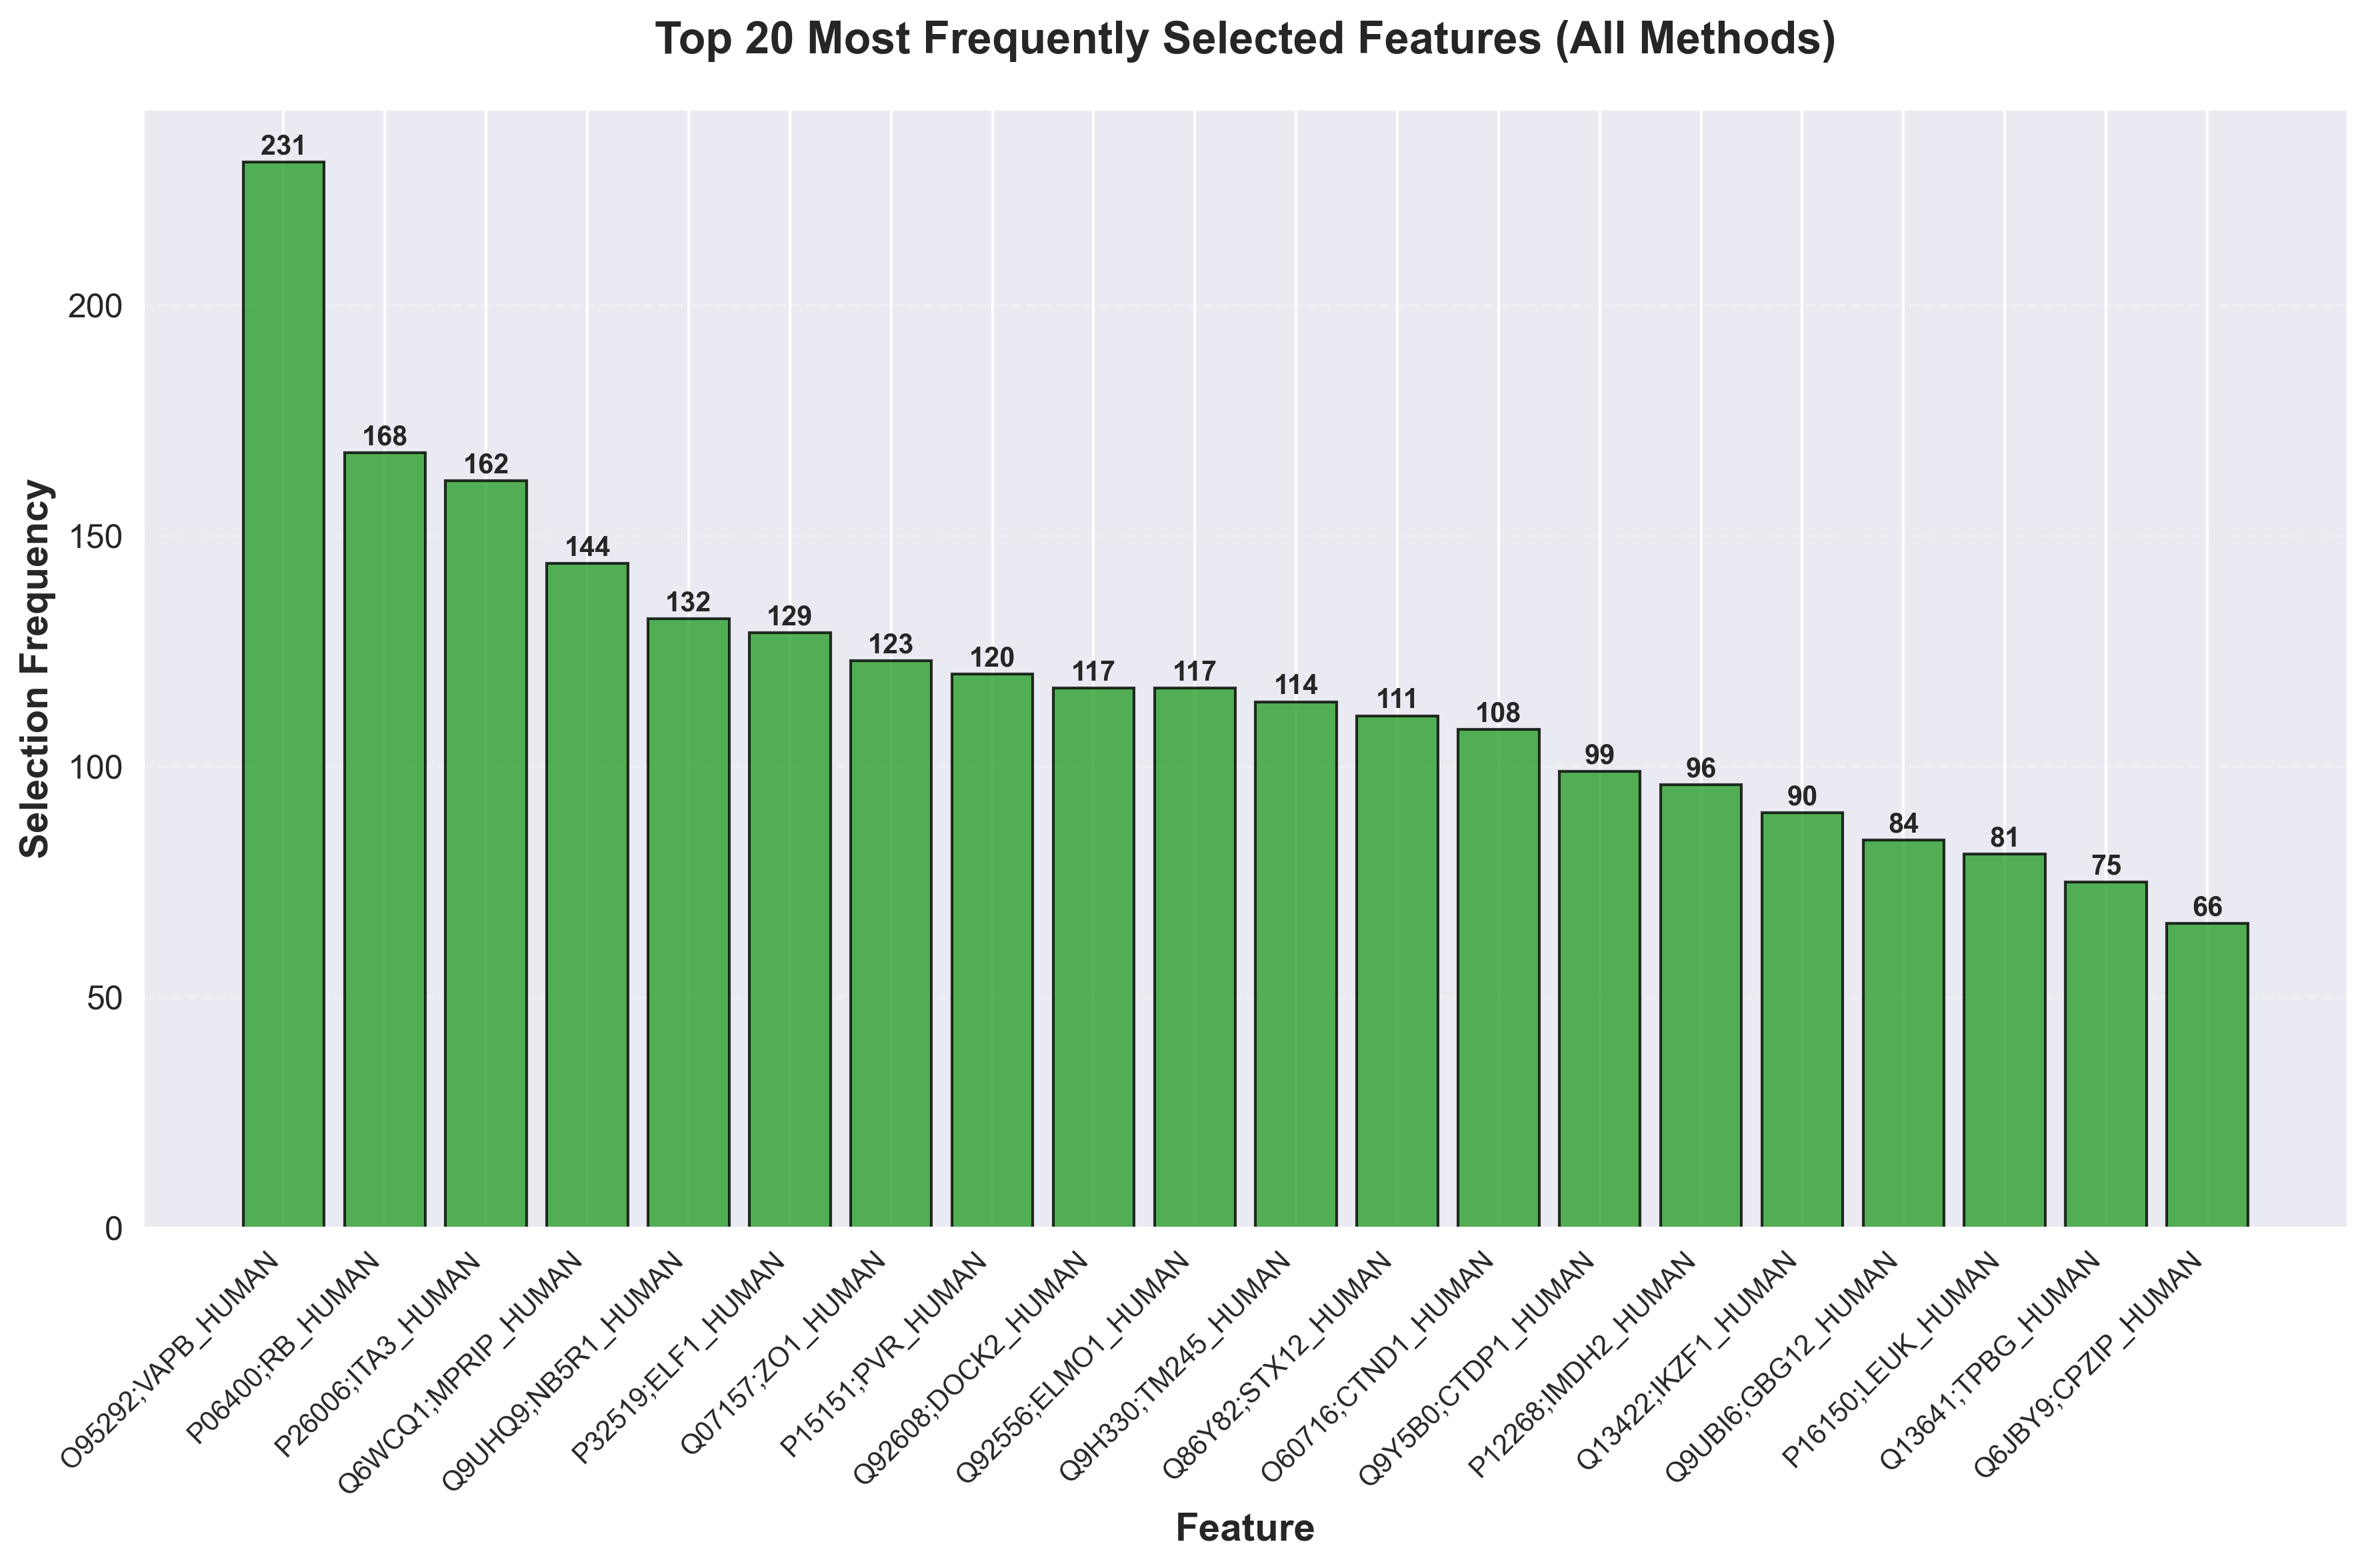

In [57]:
# Create publication-quality bar plot of top selected features
plt.figure(figsize=(12, 8), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Plot top 20 features
top_features = feature_frequency.head(20)
bars = plt.bar(range(len(top_features)), top_features.values, 
               color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=1)

plt.title('Top 20 Most Frequently Selected Features (All Methods)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature', fontsize=14, fontweight='bold')
plt.ylabel('Selection Frequency', fontsize=14, fontweight='bold')
plt.xticks(range(len(top_features)), top_features.index, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.2, linestyle='--')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{file_save_path}top_features_frequency_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# Analyze feature selection frequency by method
method_feature_freq = {}
for method in df_benchmark['method'].unique():
    method_features = []
    method_data = df_benchmark[df_benchmark['method'] == method]
    
    for idx, row in method_data.iterrows():
        selected_features = row['selected_features']
        # Handle different data types (list, numpy array, etc.)
        if hasattr(selected_features, '__iter__') and not isinstance(selected_features, (str, dict)):
            # Convert to list if it's an iterable (like numpy array)
            if hasattr(selected_features, 'tolist'):
                selected_features = selected_features.tolist()
            elif not isinstance(selected_features, list):
                selected_features = list(selected_features)
            
            if len(selected_features) > 0:
                method_features.extend(selected_features)
    
    method_feature_freq[method] = pd.Series(method_features).value_counts().sort_values(ascending=False)

# Display top features for each method
save_and_print("Top 10 features by method:", print_report_file, level="section")
for method, freq in method_feature_freq.items():
    save_and_print(f"\n{method_labels.get(method, method)}:", print_report_file, level="subsection")
    save_and_print(freq.head(10).to_string(), print_report_file, level="info")

Top 10 features by method:

Mrmr_Anova_Prefilter:
O95292;VAPB_HUMAN     120
P26006;ITA3_HUMAN     105
P15151;PVR_HUMAN      102
Q6WCQ1;MPRIP_HUMAN     93
Q92556;ELMO1_HUMAN     90
Q07157;ZO1_HUMAN       90
Q92608;DOCK2_HUMAN     90
P06400;RB_HUMAN        84
O60716;CTND1_HUMAN     84
Q13422;IKZF1_HUMAN     78

Gffs_Anova_Prefilter:
O95292;VAPB_HUMAN     111
P06400;RB_HUMAN        84
Q86Y82;STX12_HUMAN     66
P32519;ELF1_HUMAN      66
Q9H330;TM245_HUMAN     66
P26006;ITA3_HUMAN      57
Q9UHQ9;NB5R1_HUMAN     54
P06756;ITAV_HUMAN      54
P12268;IMDH2_HUMAN     51
Q6WCQ1;MPRIP_HUMAN     51


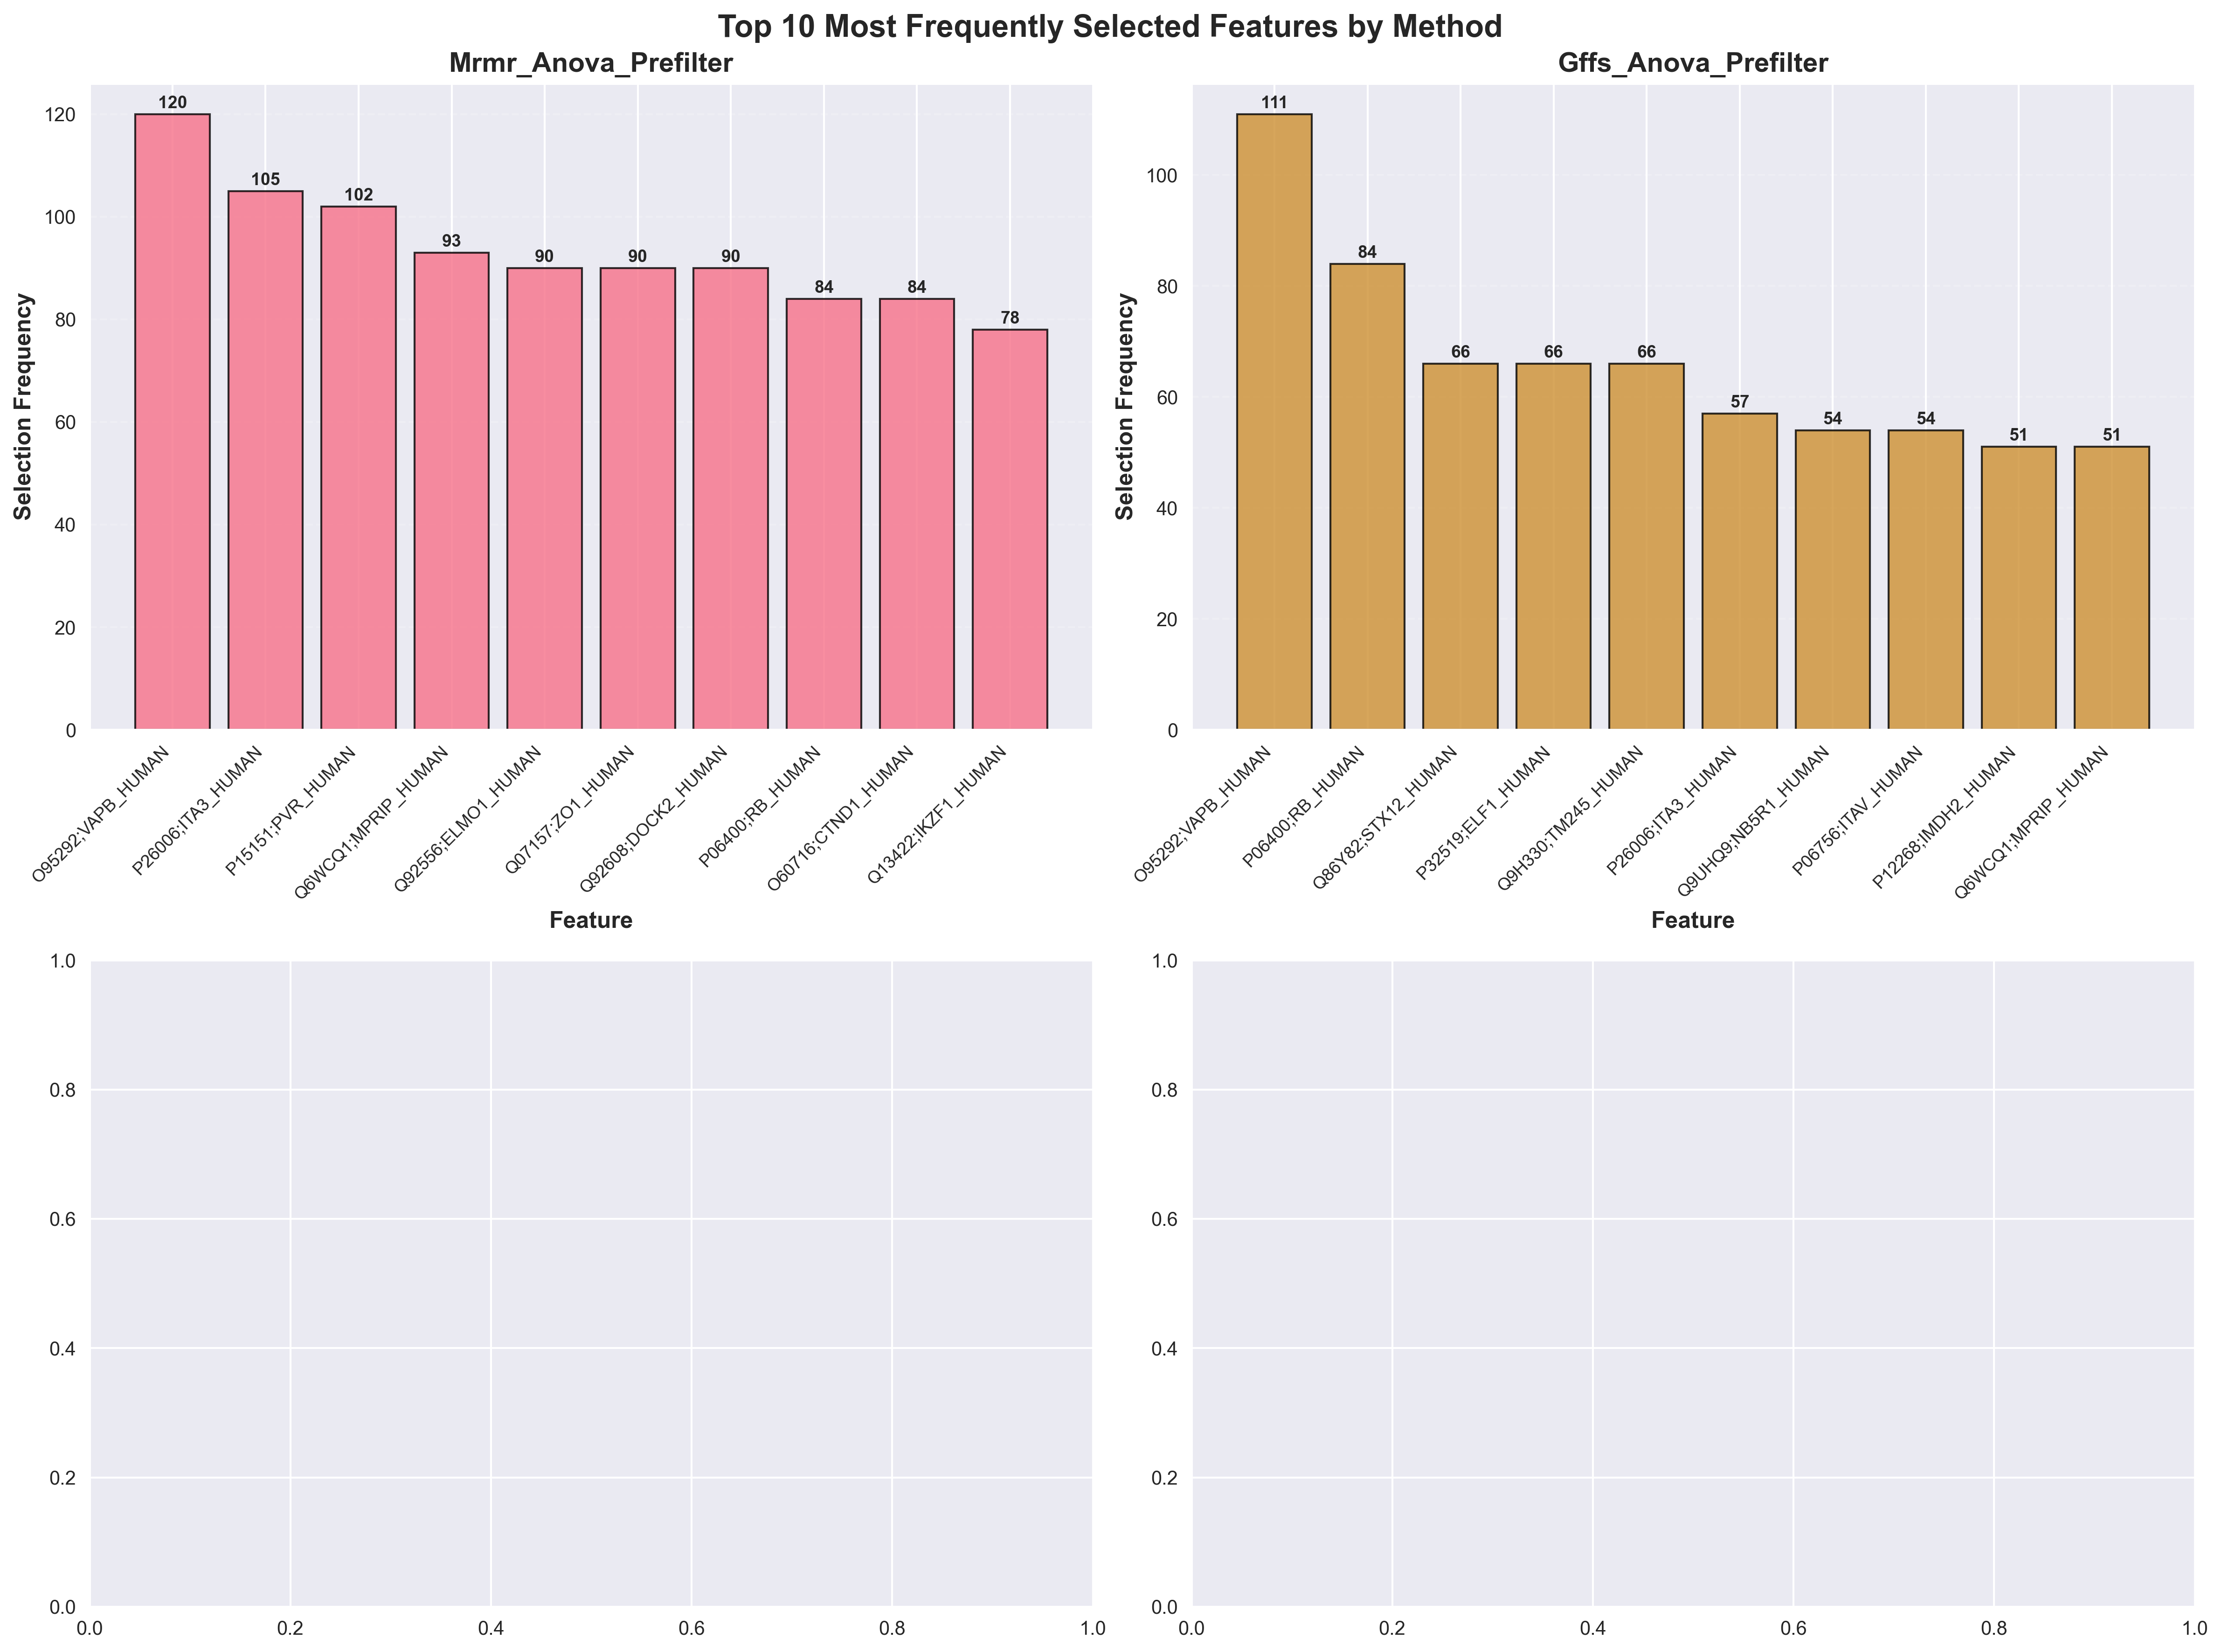

In [59]:
# Create publication-quality faceted bar plots by method
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2

# Use consistent colors for faceted bar plots
for i, method in enumerate(available_methods):
    ax = axes[i//2, i%2]
    top_method_features = method_feature_freq[method].head(10)
    
    bars = ax.bar(range(len(top_method_features)), top_method_features.values,
                  color=color_mapping[method], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_title(f'{method_labels.get(method, method)}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Selection Frequency', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(top_method_features)))
    ax.set_xticklabels(top_method_features.index, rotation=45, ha='right', fontsize=9)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', alpha=0.2, linestyle='--')
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Top 10 Most Frequently Selected Features by Method', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(f"{file_save_path}top_features_by_method_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

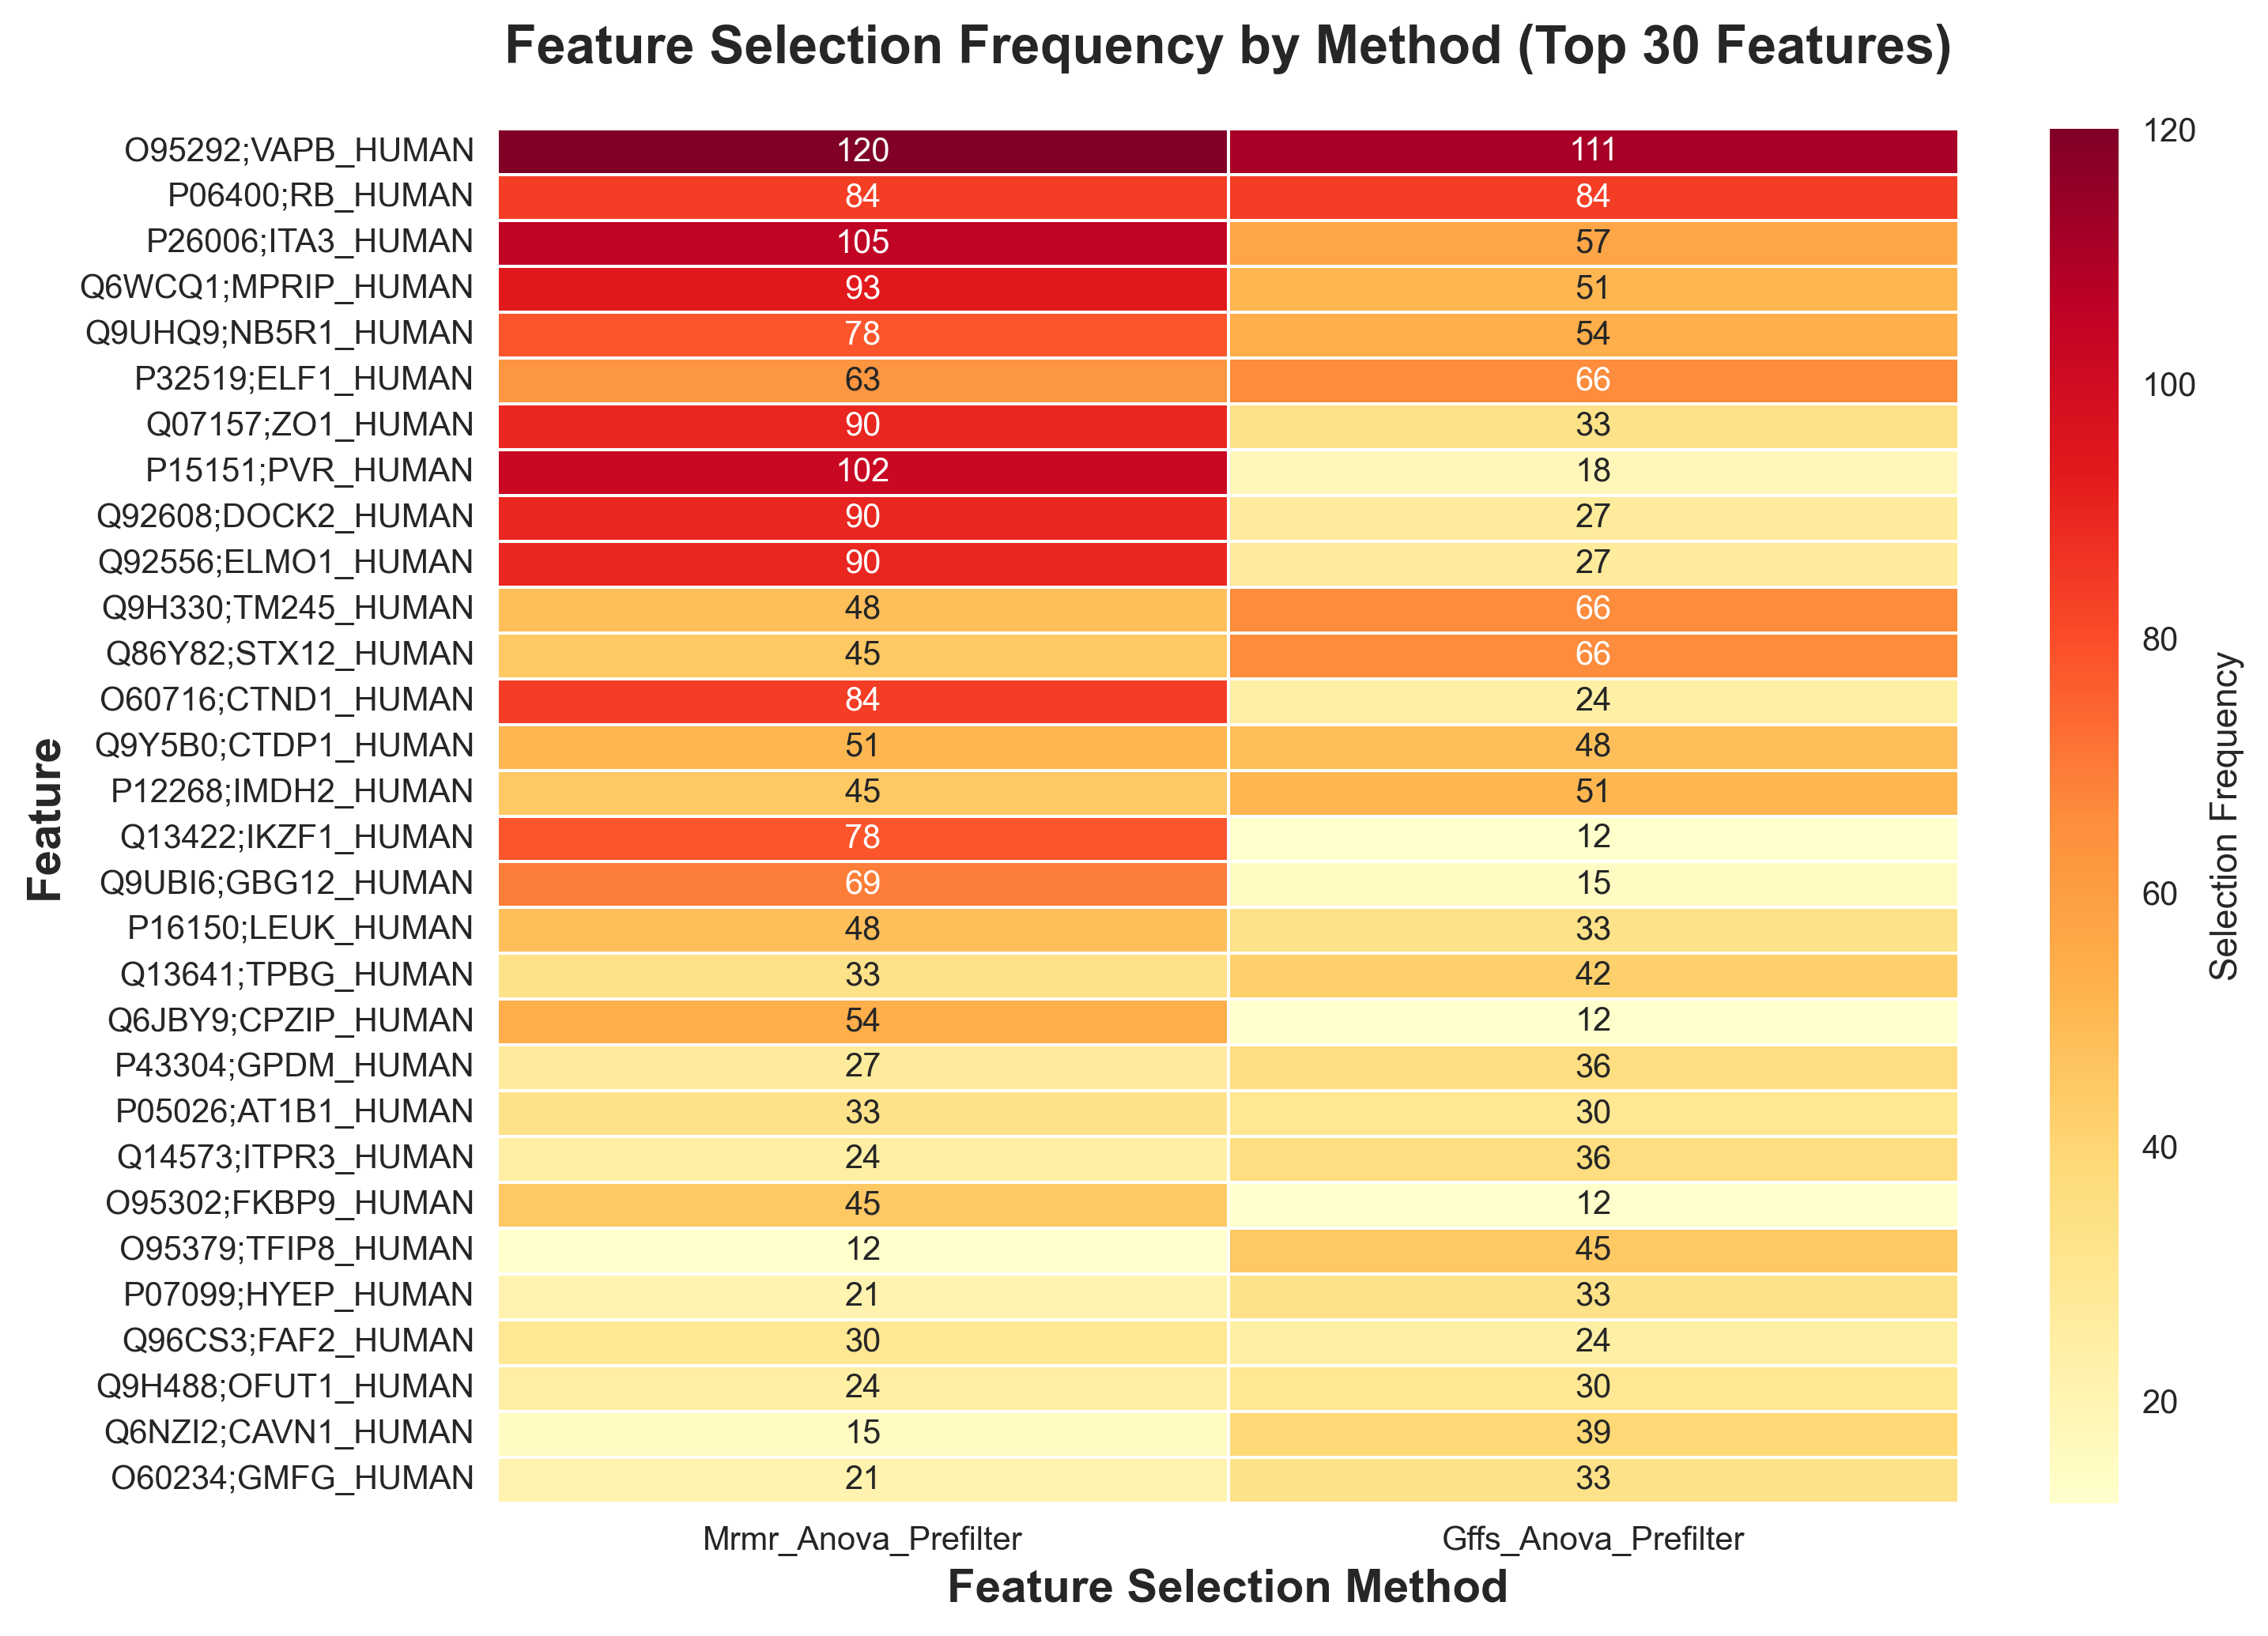

In [60]:
# Create publication-quality heatmap showing feature selection frequency by method
plt.figure(figsize=(10, 7), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2

# Get top 30 features overall
top_30_features = feature_frequency.head(30).index

# Create frequency matrix for heatmap
freq_matrix = []
for feature in top_30_features:
    row = []
    for method in available_methods:
        if feature in method_feature_freq[method]:
            row.append(method_feature_freq[method][feature])
        else:
            row.append(0)
    freq_matrix.append(row)

freq_df = pd.DataFrame(freq_matrix, index=top_30_features, 
                       columns=[method_labels.get(m, m) for m in available_methods])

# Create heatmap
sns.heatmap(freq_df, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Selection Frequency'}, 
            linewidths=0.5, linecolor='white')
plt.title('Feature Selection Frequency by Method (Top 30 Features)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{file_save_path}feature_selection_heatmap_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

In [61]:
# Summary statistics for feature selection analysis
save_and_print("Feature Selection Analysis Summary:", print_report_file, level="section")
save_and_print(f"Total feature selection events: {len(all_selected_features)}", print_report_file, level="info")
save_and_print(f"Unique features selected: {len(feature_frequency)}", print_report_file, level="info")
save_and_print(f"Average selections per feature: {len(all_selected_features) / len(feature_frequency):.1f}", print_report_file, level="info")

# Method-specific statistics
save_and_print("Method-specific statistics:", print_report_file, level="subsection")
for method in available_methods:
    method_selections = sum(len(row['selected_features']) for idx, row in df_benchmark[df_benchmark['method'] == method].iterrows() 
                           if isinstance(row['selected_features'], list))
    unique_features = len(method_feature_freq[method])
    avg_selections = method_selections / unique_features if unique_features > 0 else 0
    
    save_and_print(f"\n{method_labels.get(method, method)}:", print_report_file, level="info")
    save_and_print(f"  Total selections: {method_selections}", print_report_file, level="info")
    save_and_print(f"  Unique features: {unique_features}", print_report_file, level="info")
    save_and_print(f"  Average selections per feature: {avg_selections:.1f}", print_report_file, level="info")
    save_and_print(f"  Most frequent feature: {method_feature_freq[method].index[0]} ({method_feature_freq[method].iloc[0]} selections)", print_report_file, level="info")

# Close the print report file
print_report_file.close()
print(f"Print report saved to: {print_report_path}")

Feature Selection Analysis Summary:
Total feature selection events: 4500
Unique features selected: 124
Average selections per feature: 36.3
Method-specific statistics:

Mrmr_Anova_Prefilter:
  Total selections: 2250
  Unique features: 73
  Average selections per feature: 30.8
  Most frequent feature: O95292;VAPB_HUMAN (120 selections)

Gffs_Anova_Prefilter:
  Total selections: 2250
  Unique features: 122
  Average selections per feature: 18.4
  Most frequent feature: O95292;VAPB_HUMAN (111 selections)
Print report saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-FeatureSelectionBenchmark/v5_mrmr_vs_gffs_anova_prefilter/feature_selection_print_report_v5_mrmr_vs_gffs_anova_prefilter.md


### Feature Selection Stability Analysis (Intra-Method Jaccard Similarity)

In [62]:
# Re-open the print report file for stability analysis
print_report_file = open(print_report_path, 'a', encoding='utf-8')

# Calculate Jaccard similarity within methods across different runs
save_and_print("Analyzing feature selection stability using intra-method Jaccard similarity...", print_report_file, level="section")

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    if len(set1) == 0 and len(set2) == 0:
        return 1.0  # Both empty sets are considered identical
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

# Group runs by method and k-value
stability_analysis = {}
# Use dynamically detected methods
methods = available_methods

for method in methods:
    method_data = df_benchmark[df_benchmark['method'] == method]
    stability_analysis[method] = {}
    
    for k_value in feature_set_sizes:
        k_data = method_data[method_data['k_value'] == k_value]
        
        if len(k_data) < 2:
            # Need at least 2 runs to calculate similarity
            stability_analysis[method][k_value] = {'mean_jaccard': np.nan, 'std_jaccard': np.nan, 'n_runs': len(k_data)}
            continue
        
        # Extract feature sets for this method and k-value
        feature_sets = []
        for idx, row in k_data.iterrows():
            selected_features = row['selected_features']
            # Handle different data types
            if hasattr(selected_features, '__iter__') and not isinstance(selected_features, (str, dict)):
                if hasattr(selected_features, 'tolist'):
                    selected_features = selected_features.tolist()
                elif not isinstance(selected_features, list):
                    selected_features = list(selected_features)
                feature_sets.append(set(selected_features))
        
        # Calculate pairwise Jaccard similarities
        jaccard_similarities = []
        for i in range(len(feature_sets)):
            for j in range(i + 1, len(feature_sets)):
                similarity = jaccard_similarity(feature_sets[i], feature_sets[j])
                jaccard_similarities.append(similarity)
        
        if len(jaccard_similarities) > 0:
            stability_analysis[method][k_value] = {
                'mean_jaccard': np.mean(jaccard_similarities),
                'std_jaccard': np.std(jaccard_similarities),
                'n_runs': len(k_data),
                'n_comparisons': len(jaccard_similarities)
            }
        else:
            stability_analysis[method][k_value] = {'mean_jaccard': np.nan, 'std_jaccard': np.nan, 'n_runs': len(k_data)}

# Display stability analysis results
save_and_print("Intra-Method Feature Selection Stability (Jaccard Similarity):", print_report_file, level="subsection")
for method in methods:
    save_and_print(f"\n{method_labels.get(method, method)}:", print_report_file, level="info")
    for k_value in feature_set_sizes:
        if k_value in stability_analysis[method]:
            stats = stability_analysis[method][k_value]
            if not np.isnan(stats['mean_jaccard']):
                save_and_print(f"  k={k_value}: Mean Jaccard = {stats['mean_jaccard']:.3f} ± {stats['std_jaccard']:.3f} "
                      f"(n_runs={stats['n_runs']}, comparisons={stats['n_comparisons']})", print_report_file, level="info")

Analyzing feature selection stability using intra-method Jaccard similarity...
Intra-Method Feature Selection Stability (Jaccard Similarity):

Mrmr_Anova_Prefilter:
  k=5: Mean Jaccard = 0.373 ± 0.234 (n_runs=30, comparisons=435)
  k=10: Mean Jaccard = 0.542 ± 0.177 (n_runs=30, comparisons=435)
  k=20: Mean Jaccard = 0.591 ± 0.139 (n_runs=30, comparisons=435)
  k=40: Mean Jaccard = 0.630 ± 0.117 (n_runs=30, comparisons=435)

Gffs_Anova_Prefilter:
  k=5: Mean Jaccard = 0.274 ± 0.264 (n_runs=30, comparisons=435)
  k=10: Mean Jaccard = 0.280 ± 0.223 (n_runs=30, comparisons=435)
  k=20: Mean Jaccard = 0.258 ± 0.210 (n_runs=30, comparisons=435)
  k=40: Mean Jaccard = 0.294 ± 0.198 (n_runs=30, comparisons=435)


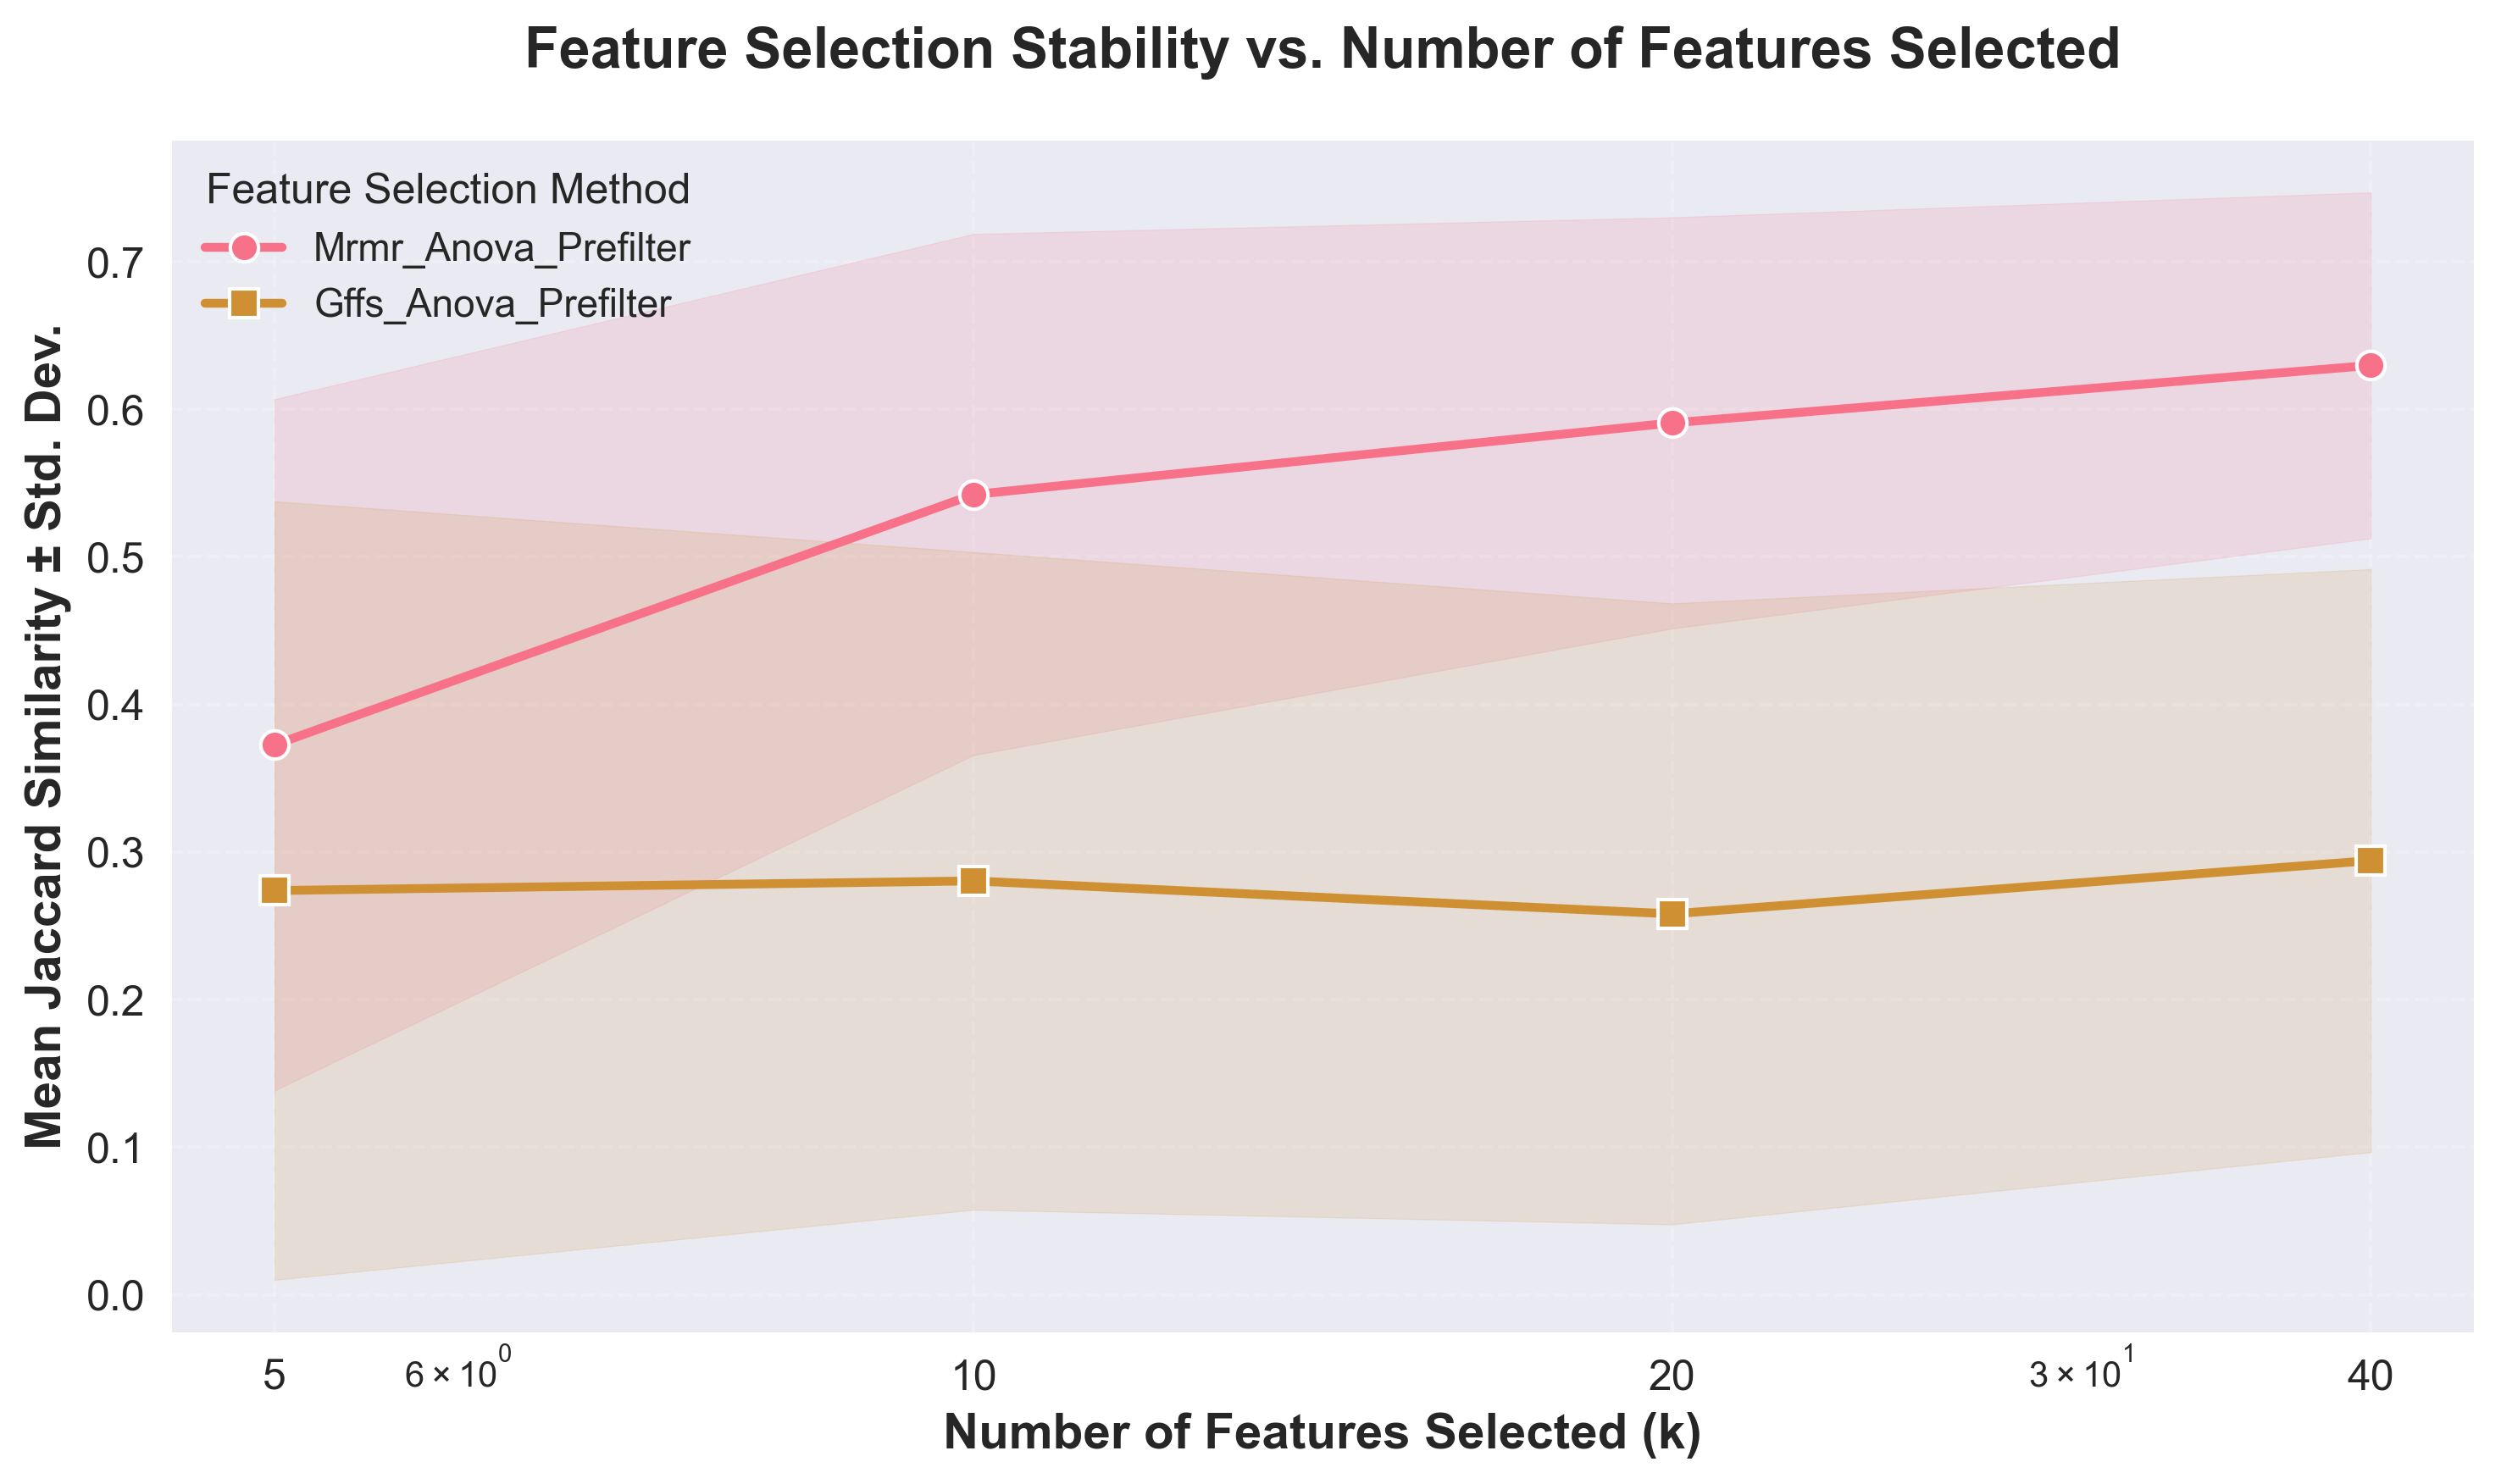

In [63]:
# Create publication-quality line plot showing stability vs. k-value
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Use consistent colors and markers for stability plot
for i, method in enumerate(methods):
    k_values = []
    mean_jaccards = []
    std_jaccards = []
    
    for k_value in feature_set_sizes:
        if k_value in stability_analysis[method] and not np.isnan(stability_analysis[method][k_value]['mean_jaccard']):
            k_values.append(k_value)
            mean_jaccards.append(stability_analysis[method][k_value]['mean_jaccard'])
            std_jaccards.append(stability_analysis[method][k_value]['std_jaccard'])
    
    if len(k_values) > 0:
        plt.plot(k_values, mean_jaccards, 
                 marker=marker_mapping[method], linewidth=2.5, markersize=8, 
                 color=color_mapping[method], markeredgecolor='white', markeredgewidth=1,
                 label=method_labels.get(method, method))
        
        # Add standard deviation bands
        plt.fill_between(k_values, 
                         np.array(mean_jaccards) - np.array(std_jaccards),
                         np.array(mean_jaccards) + np.array(std_jaccards),
                         alpha=0.15, color=color_mapping[method])

plt.title('Feature Selection Stability vs. Number of Features Selected', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Jaccard Similarity ± Std. Dev.', fontsize=14, fontweight='bold')
plt.xscale('log')  # Use log scale for better visualization
plt.xticks(feature_set_sizes, feature_set_sizes, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Feature Selection Method', fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}stability_vs_k_value_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# Calculate overall stability metrics for each method
overall_stability = {}
for method in methods:
    all_jaccards = []
    for k_value in feature_set_sizes:
        if k_value in stability_analysis[method] and not np.isnan(stability_analysis[method][k_value]['mean_jaccard']):
            # Get individual Jaccard values for this k-value (approximate by using mean)
            n_comparisons = stability_analysis[method][k_value]['n_comparisons']
            if n_comparisons > 0:
                mean_jaccard = stability_analysis[method][k_value]['mean_jaccard']
                # Add multiple instances weighted by number of comparisons
                all_jaccards.extend([mean_jaccard] * n_comparisons)
    
    if len(all_jaccards) > 0:
        overall_stability[method] = {
            'mean_jaccard': np.mean(all_jaccards),
            'std_jaccard': np.std(all_jaccards),
            'total_comparisons': len(all_jaccards)
        }
    else:
        overall_stability[method] = {'mean_jaccard': np.nan, 'std_jaccard': np.nan, 'total_comparisons': 0}

# Display overall stability summary
save_and_print("Overall Feature Selection Stability Summary:", print_report_file, level="subsection")
for method in methods:
    if method in overall_stability and not np.isnan(overall_stability[method]['mean_jaccard']):
        stats = overall_stability[method]
        save_and_print(f"{method_labels.get(method, method)}: "
              f"Mean Jaccard = {stats['mean_jaccard']:.3f} ± {stats['std_jaccard']:.3f} "
              f"(total comparisons={stats['total_comparisons']})", print_report_file, level="info")

Overall Feature Selection Stability Summary:
Mrmr_Anova_Prefilter: Mean Jaccard = 0.534 ± 0.098 (total comparisons=1740)
Gffs_Anova_Prefilter: Mean Jaccard = 0.277 ± 0.013 (total comparisons=1740)


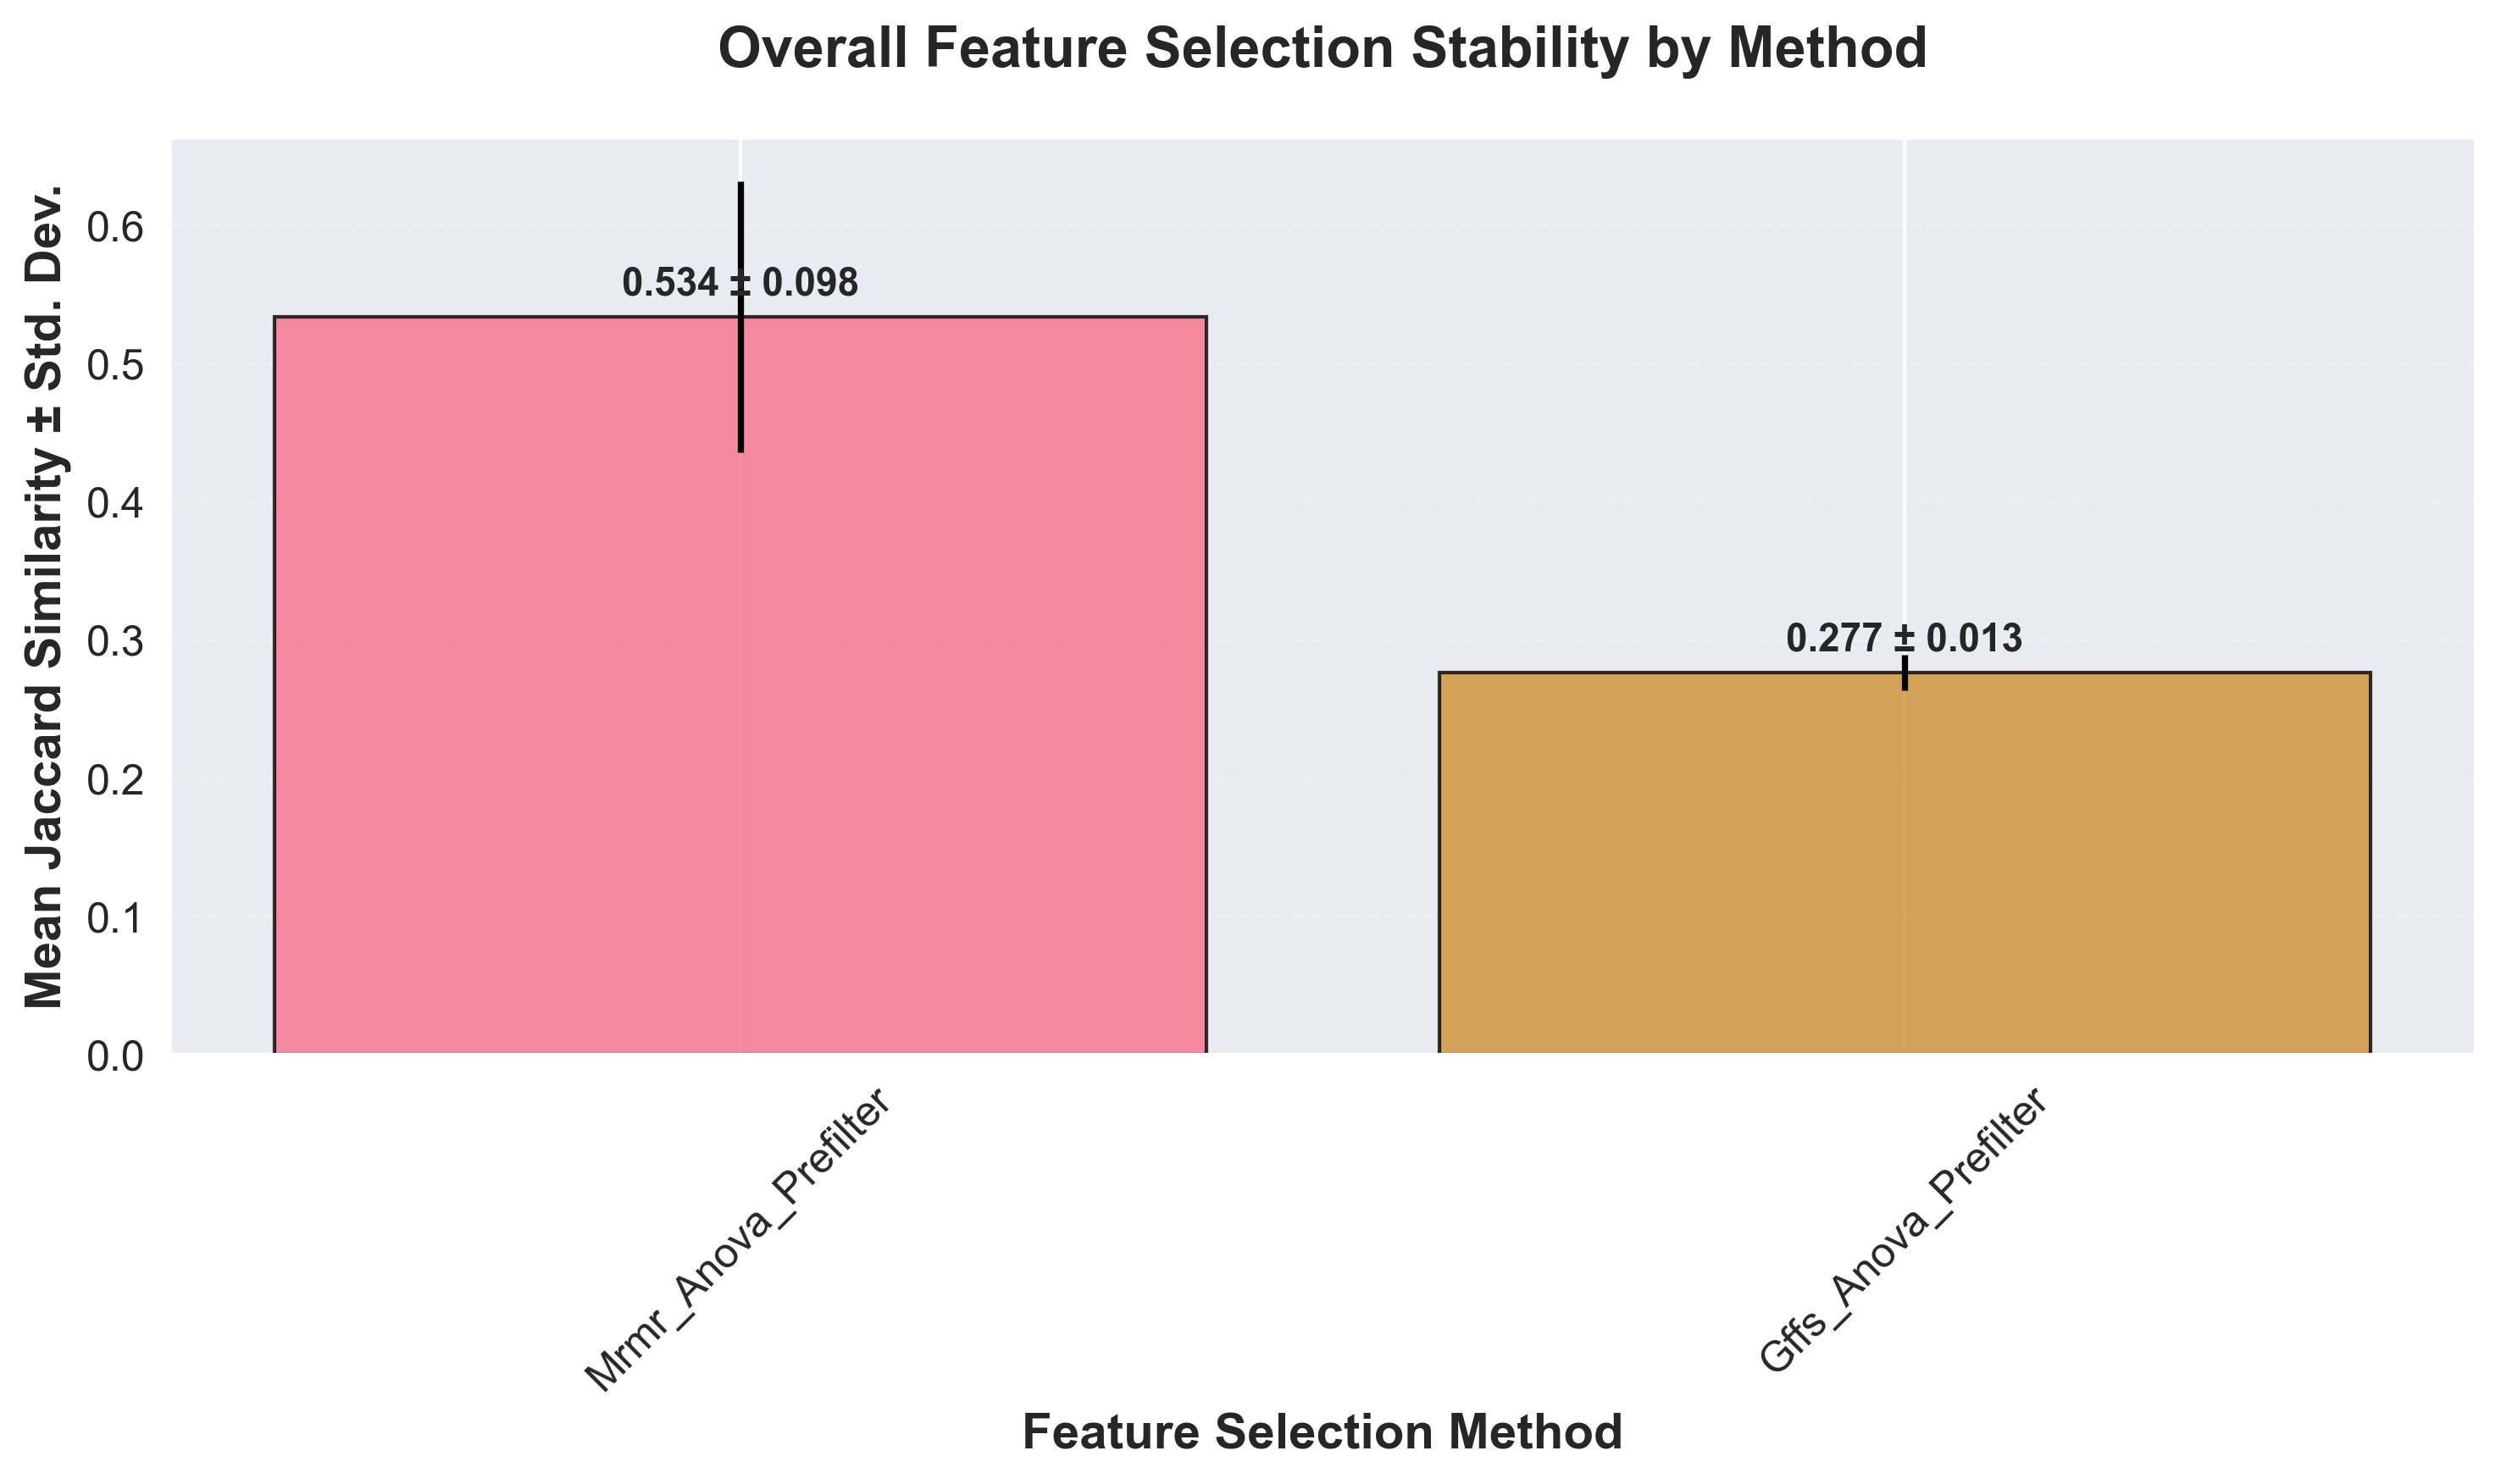

In [65]:
# Create publication-quality bar plot comparing overall stability
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Prepare data for bar plot
methods_plot = []
mean_jaccards = []
std_jaccards = []

for method in methods:
    if method in overall_stability and not np.isnan(overall_stability[method]['mean_jaccard']):
        methods_plot.append(method_labels.get(method, method))
        mean_jaccards.append(overall_stability[method]['mean_jaccard'])
        std_jaccards.append(overall_stability[method]['std_jaccard'])

if len(methods_plot) > 0:
    bar_colors = [color_mapping[method] for method in methods if method in overall_stability and not np.isnan(overall_stability[method]['mean_jaccard'])]
    bars = plt.bar(range(len(methods_plot)), mean_jaccards, 
                   yerr=std_jaccards, capsize=8, alpha=0.8,
                   color=bar_colors, edgecolor='black', linewidth=1)
    
    plt.title('Overall Feature Selection Stability by Method', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Jaccard Similarity ± Std. Dev.', fontsize=14, fontweight='bold')
    plt.xticks(range(len(methods_plot)), methods_plot, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f} ± {std_jaccards[i]:.3f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.2, linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}overall_stability_comparison_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()

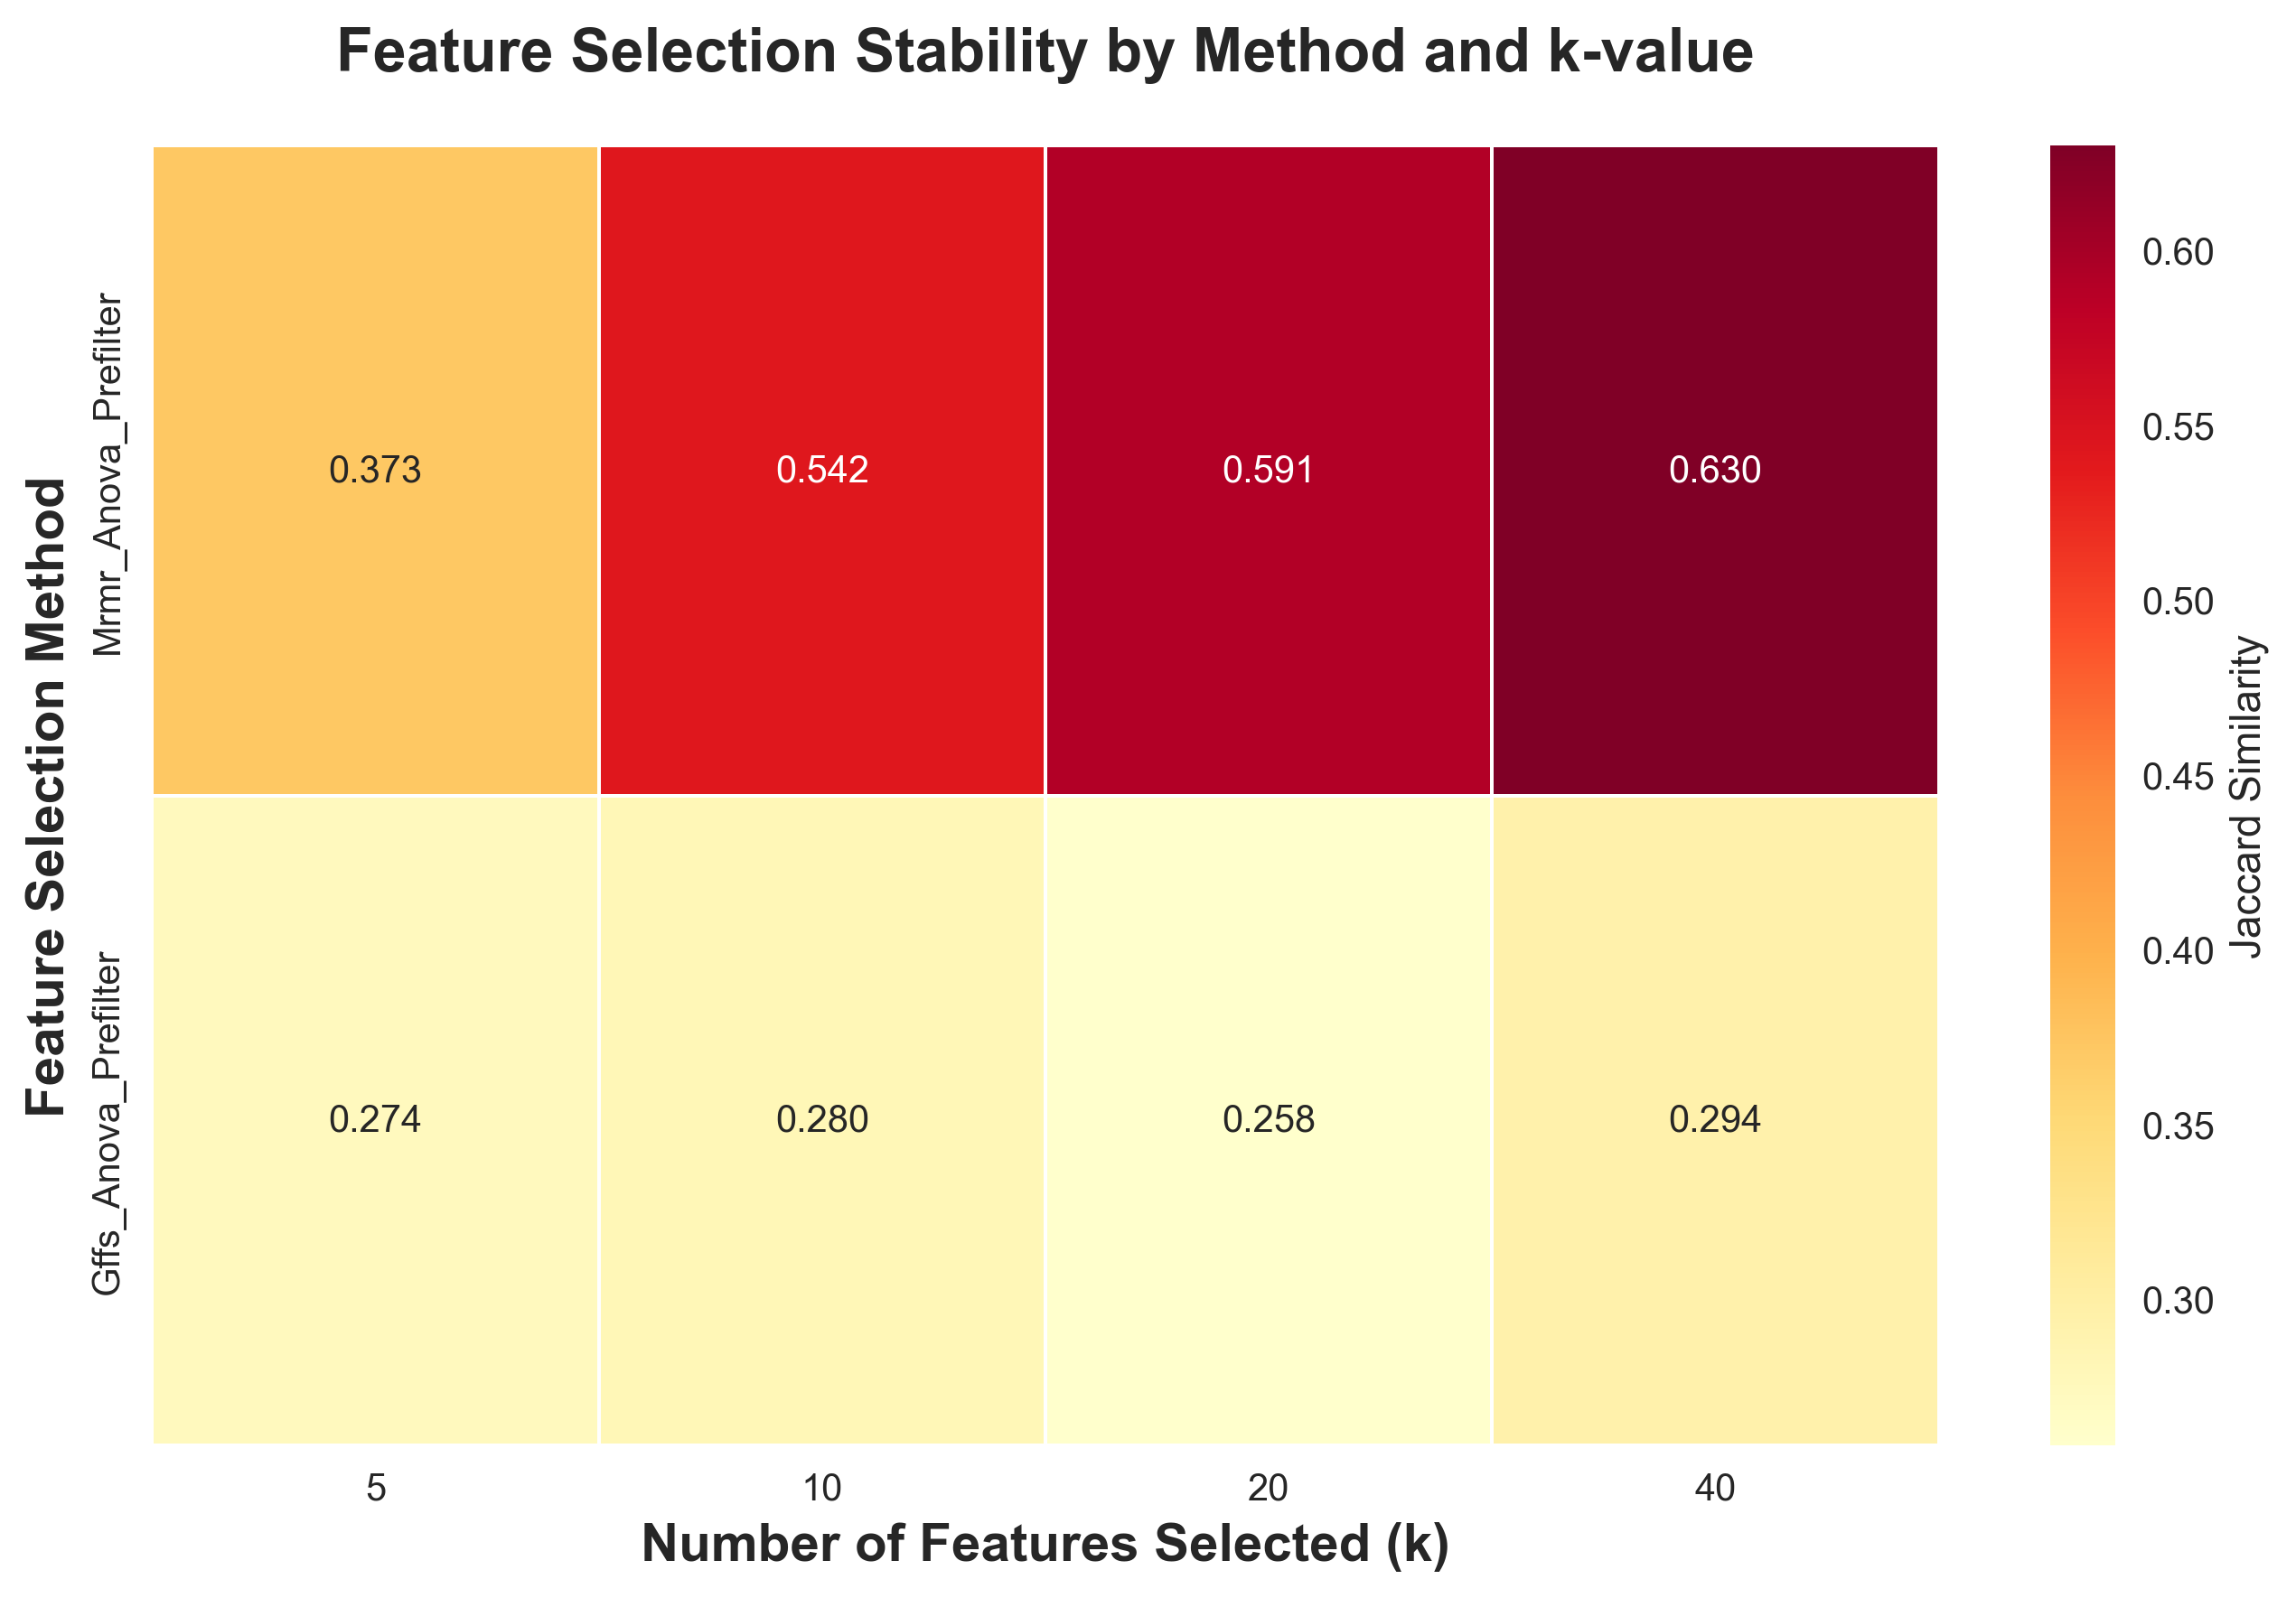

In [66]:
# Create stability heatmap by method and k-value
plt.figure(figsize=(9, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2

# Create stability matrix for heatmap
stability_matrix = []
for method in methods:
    row = []
    for k_value in feature_set_sizes:
        if k_value in stability_analysis[method] and not np.isnan(stability_analysis[method][k_value]['mean_jaccard']):
            row.append(stability_analysis[method][k_value]['mean_jaccard'])
        else:
            row.append(np.nan)
    stability_matrix.append(row)

stability_df = pd.DataFrame(stability_matrix, index=[method_labels.get(m, m) for m in methods], 
                           columns=feature_set_sizes)

# Create heatmap
sns.heatmap(stability_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Jaccard Similarity'}, 
            linewidths=0.5, linecolor='white')
plt.title('Feature Selection Stability by Method and k-value', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Feature Selection Method', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{file_save_path}stability_heatmap_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

In [67]:
# Statistical comparison of stability between methods
save_and_print("Statistical Comparison of Feature Selection Stability:", print_report_file, level="subsection")

# Collect all Jaccard values for statistical comparison
method_jaccards = {}
for method in methods:
    jaccards = []
    for k_value in feature_set_sizes:
        if k_value in stability_analysis[method] and not np.isnan(stability_analysis[method][k_value]['mean_jaccard']):
            n_comparisons = stability_analysis[method][k_value]['n_comparisons']
            mean_jaccard = stability_analysis[method][k_value]['mean_jaccard']
            jaccards.extend([mean_jaccard] * n_comparisons)
    method_jaccards[method] = jaccards

# Compare methods pairwise
from scipy.stats import ttest_ind

for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        if i < j and len(method_jaccards[method1]) > 0 and len(method_jaccards[method2]) > 0:
            t_stat, p_value = ttest_ind(method_jaccards[method1], method_jaccards[method2])
            save_and_print(f"{method_labels.get(method1, method1)} vs {method_labels.get(method2, method2)}: "
                  f"t={t_stat:.3f}, p={p_value:.4f}", print_report_file, level="info")

Statistical Comparison of Feature Selection Stability:
Mrmr_Anova_Prefilter vs Gffs_Anova_Prefilter: t=108.390, p=0.0000


In [68]:
# Summary of stability analysis
save_and_print("Feature Selection Stability Analysis Summary:", print_report_file, level="section")

# Rank methods by stability
stability_ranking = []
for method in methods:
    if method in overall_stability and not np.isnan(overall_stability[method]['mean_jaccard']):
        stability_ranking.append((method, overall_stability[method]['mean_jaccard']))

stability_ranking.sort(key=lambda x: x[1], reverse=True)

save_and_print("Stability Ranking (Highest to Lowest):", print_report_file, level="subsection")
for i, (method, stability) in enumerate(stability_ranking, 1):
    save_and_print(f"{i}. {method_labels.get(method, method)}: {stability:.3f}", print_report_file, level="info")

# Close the print report file
print_report_file.close()
print(f"Print report saved to: {print_report_path}")

Feature Selection Stability Analysis Summary:
Stability Ranking (Highest to Lowest):
1. Mrmr_Anova_Prefilter: 0.534
2. Gffs_Anova_Prefilter: 0.277
Print report saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-FeatureSelectionBenchmark/v5_mrmr_vs_gffs_anova_prefilter/feature_selection_print_report_v5_mrmr_vs_gffs_anova_prefilter.md
